In [3]:
import cv2
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
import seaborn as sns
import h5py as hf
from tqdm import tqdm
import itertools 
from scipy.interpolate import interp1d
from scipy import signal
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

#import sys3

from utils.base_functions import format_frames,flatten_column,list_columns
from src.utils.auxiliary import flatten_series

import warnings
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'sys3'

In [87]:
df= pd.read_hdf(r'C:\Users\nlab\obstacle_avoidance\recordings\101322\J20LT\oa\raw_J20LT_101322_oa.h5')


In [88]:
## smooth traces of body parts
keys = ['nose','leftear','rightear','spine','midspine']
fake_time = np.linspace(0,1,200)
box_sz = 5 
box = np.ones(box_sz)/box_sz

count = 0
for ind, row in df.iterrows():
    for key in keys:
        xT = np.linspace(0,1,len(row[key + '_x'])); yT = np.linspace(0,1,len(row[key + '_y']))
        intx = interp1d(xT, row[key + '_x_cm'], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
        inty = interp1d(yT, row[key + '_y_cm'], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
        fillx = pd.Series(intx).fillna(method='bfill').to_numpy()
        filly = pd.Series(inty).fillna(method='bfill').to_numpy()
        #smoothx = np.convolve(signal.medfilt(fillx,kernel_size=3), box, mode='same')
        #smoothy = np.convolve(signal.medfilt(filly,kernel_size=3), box, mode='same')
    #trace = np.hstack((smoothx,smoothy))
    #data[count,:] = trace
        count += 1
        df.at[ind,'interp_' + key+ '_x_cm'] = fillx.astype(object)
        df.at[ind,'interp_' + key+ '_y_cm'] = filly.astype(object)

In [ ]:
keys = ['nose','leftear','rightear','spine','midspine','obstacle']
keys_list = list_columns(df,keys)

In [2]:
import sys
sys.path.insert(0, 'C:/Users/nlab/Documents/GitHub/obstacle_avoidance')
from plots.plots import plot_oa

SyntaxError: invalid syntax (plots.py, line 77)

In [91]:
## get index of obstacle,bodyparts after mouse reaches a ceartin x postion

# get list of columns need for re in
keys = ['nose','leftear','rightear','spine','midspine','obstacle']
keys_list = list_columns(df,keys)
keys_list= [col for col in keys_list if 'likelihood' not in col]
keys_list= [col for col in keys_list if 'lind' not in col]



# check if odd or even trial
#  get first index when nose crosses a distance thresh hold
##odd tiral at 16 cm even at 56 cm 



for ind, row in df.iterrows(): 
    if row['odd'] == True:
        nose_list = row['nose_x_cm'] 
        odd_ind = np.argmax(nose_list>16)
        for key in keys_list:
            df.at[ind,'gt_' + key] = row[key][odd_ind:]
        #use odd_ind to index into obstacle 
        # iterate over columns list  

        #create gt_obstacle points
    else: 
        nose_list = row['nose_x_cm']
        even_ind = np.argmax(nose_list<56)
        for key in keys_list:
            df.at[ind,'gt_' + key] = row[key][even_ind:]

##  median point at gt obstacle 
obstacle_cols = list_columns(df,['obstacle'])
obstacle_cols = [col for col in obstacle_cols if 'gt_' in col]
for ind, row in df.iterrows():
    # calculate median of each corner
    for col in obstacle_cols:
        df.at[ind,'median_'+ col]= np.nanmedian(row[col])
        
       
        

## get obstacle center        

    
for ind, row in df.iterrows():
  
  xvals = np.stack([row['gt_obstacleTL_x'], row['gt_obstacleTR_x'], row['gt_obstacleBL_x'], row['gt_obstacleBR_x']])
  xvals_cm = np.stack([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBL_x_cm'], row['gt_obstacleBR_x_cm']])
  df.at[ind,'gt_obstacle_cen_x' ] = np.nanmedian(xvals)
  df.at[ind,'gt_obstacle_cen_x_cm' ] = np.nanmedian(xvals_cm)
  
  yvals = np.stack([row['gt_obstacleTL_y'], row['gt_obstacleTR_y'], row['gt_obstacleBL_y'], row['gt_obstacleBR_y']])
  yvals_cm = np.stack([row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBL_y_cm'], row['gt_obstacleBR_y_cm']])
  df.at[ind,'gt_obstacle_cen_y' ] = np.nanmedian(yvals)
  df.at[ind,'gt_obstacle_cen_y_cm' ] = np.nanmedian(yvals_cm)
  

     

In [67]:
## calculate arena center
for ind, row in df.iterrows(): 
    xvals_cm = np.stack([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']])
    xvals = np.stack([row['arenaTL_x'], row['arenaTR_x'], row['arenaBL_x'], row['arenaBR_x']])
    df.at[ind,'arena_cen_x_cm'] = np.nanmedian(xvals_cm)
    df.at[ind,'arena_cen_x'] = np.nanmedian(xvals)


    yvals_cm = np.stack([row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']])
    yvals = np.stack([row['arenaTL_y'], row['arenaTR_y'], row['arenaBL_y'], row['arenaBR_y']])
    df.at[ind,'arena_cen_y_cm'] = np.nanmedian(yvals_cm)
    df.at[ind,'arena_cen_y'] = np.nanmedian(yvals)

In [68]:
# normalize trial postiions to center obstacle center on the center oft the plot. 
#test = df.sample(1)
a_o = ['arena','obstacle','arena']
columns_list = []
for poi in a_o: 
    columns = [col for col in df.columns if poi in col]
    columns_list.append(columns)
columns_list = list(itertools.chain(*columns_list))
columns_list = [col for col in columns_list if '_cm' in col ]
columns_list = [col for col in columns_list if 'lind' not in col ]


for ind, row in df.iterrows():
    x_diff = row['gt_obstacle_cen_x_cm'] - row['arena_cen_x_cm'] 
    y_diff = row['gt_obstacle_cen_y_cm'] - row['arena_cen_y_cm'] 
    ## re center obstacle and area points
    for col in columns_list:
        if 'y' in col:
            if y_diff < 0:
                df.at[ind,'recen_' + col] = row[col] - y_diff
            else:
                df.at[ind,'recen_' + col] = row[col] - y_diff

            
        else:
            if x_diff < 0:
                df.at[ind,'recen_' + col] = row[col] - x_diff
            else:
                df.at[ind,'recen_' + col] = row[col] - x_diff

In [69]:
## normalize 
nose_parts= [col for col in df.columns if 'nose' in col]
nose_parts = [col for col in nose_parts if 'likelihood' not in col]
for ind, row in df.iterrows():
    x_diff = row['gt_obstacle_cen_x_cm'] - row['arena_cen_x_cm'] 
    y_diff = row['gt_obstacle_cen_y_cm'] - row['arena_cen_y_cm'] 
    ## re center obstacle and area points
    for col in nose_parts:
        if 'y' in col:
            if y_diff < 0:
                df.at[ind,'recen_' + col] = row[col] - y_diff
            else:
                df.at[ind,'recen_' + col] = row[col] - y_diff

            
        else:
            if x_diff < 0:
                df.at[ind,'recen_' + col] = row[col] - x_diff
            else:
                df.at[ind,'recen_' + col] = row[col] - x_diff

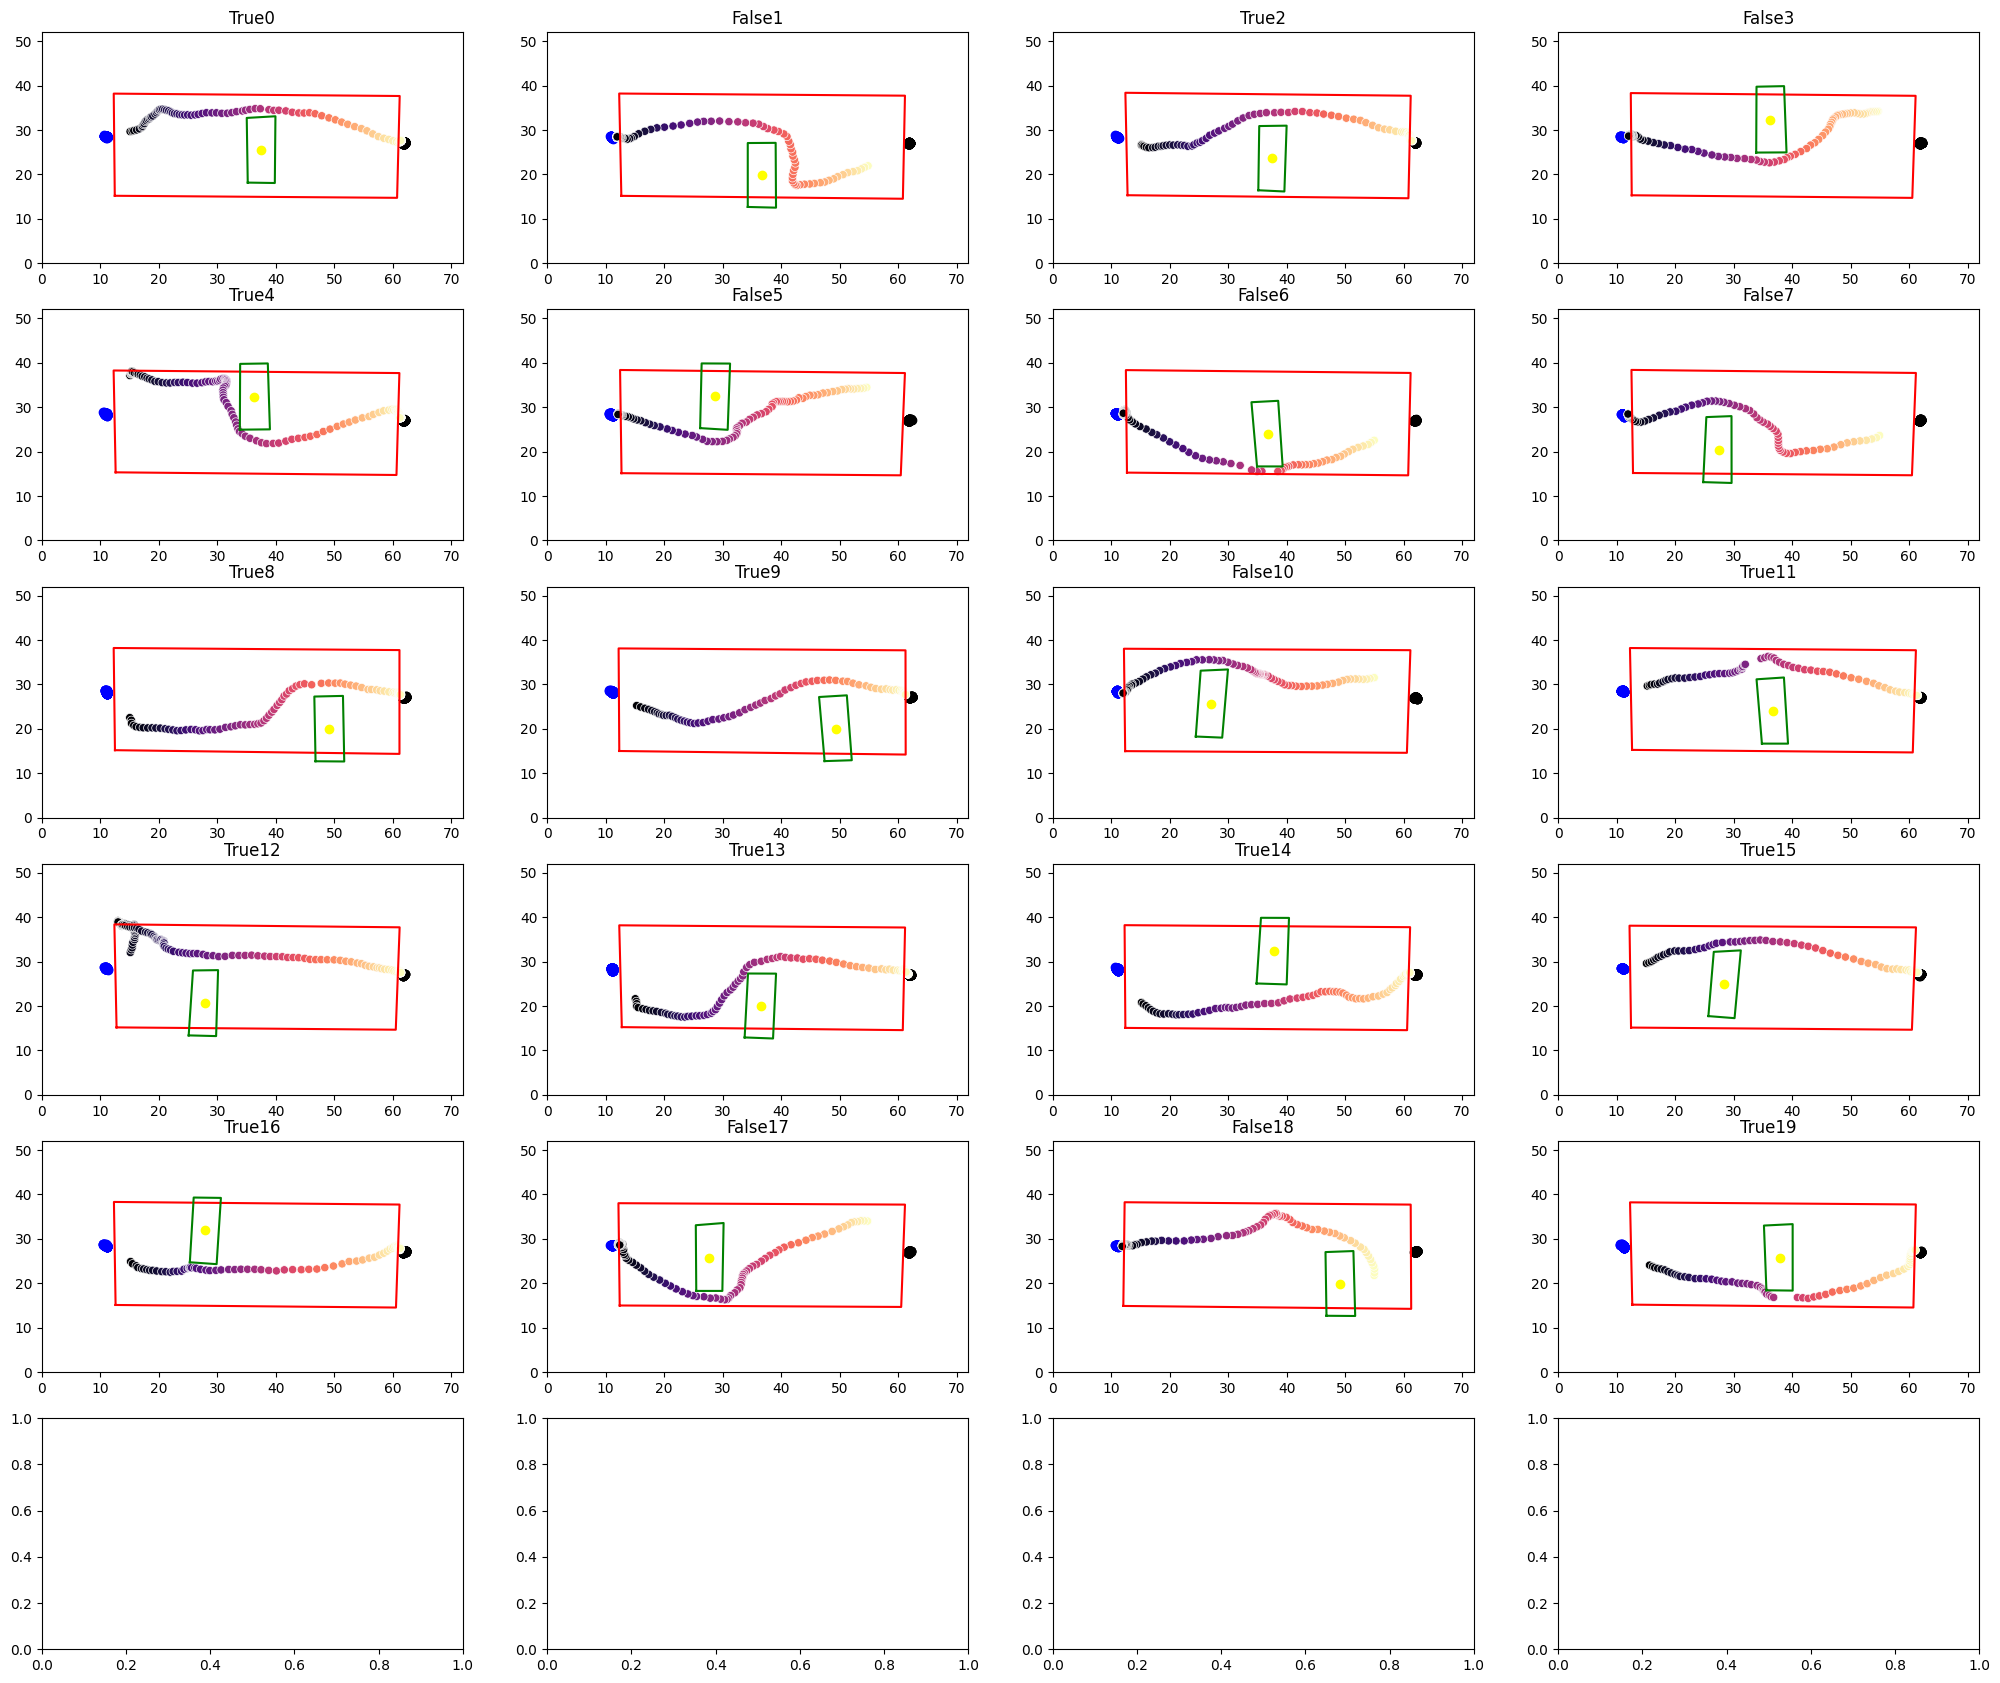

In [73]:
plt.subplots(6,4, figsize=(25,21))
for ind, row in test.iterrows():
    plt.subplot(6,4,ind +1)
    plt.xlim([0,72])
    plt.ylim([0,52])
    plt.gca().set_title(str(row['odd'])+str(ind))
    
    plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


    plt.plot([row['median_gt_obstacleTL_x_cm'], row['median_gt_obstacleTR_x_cm'], row['median_gt_obstacleBR_x_cm'], row['median_gt_obstacleBL_x_cm'],row['median_gt_obstacleTL_x_cm']],
                [row['median_gt_obstacleTL_y_cm'], row['median_gt_obstacleTR_y_cm'], row['median_gt_obstacleBR_y_cm'], row['median_gt_obstacleBL_y_cm'],row['median_gt_obstacleTL_y_cm']],color='green')
    
   
    
    
    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='yellow')
    plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
    plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
    
    

   
    sns.scatterplot(x=row['gt_nose_x_cm'],y=row['gt_nose_y_cm'],hue = row['gt_nose_x_cm'], palette ='magma',legend=False) 

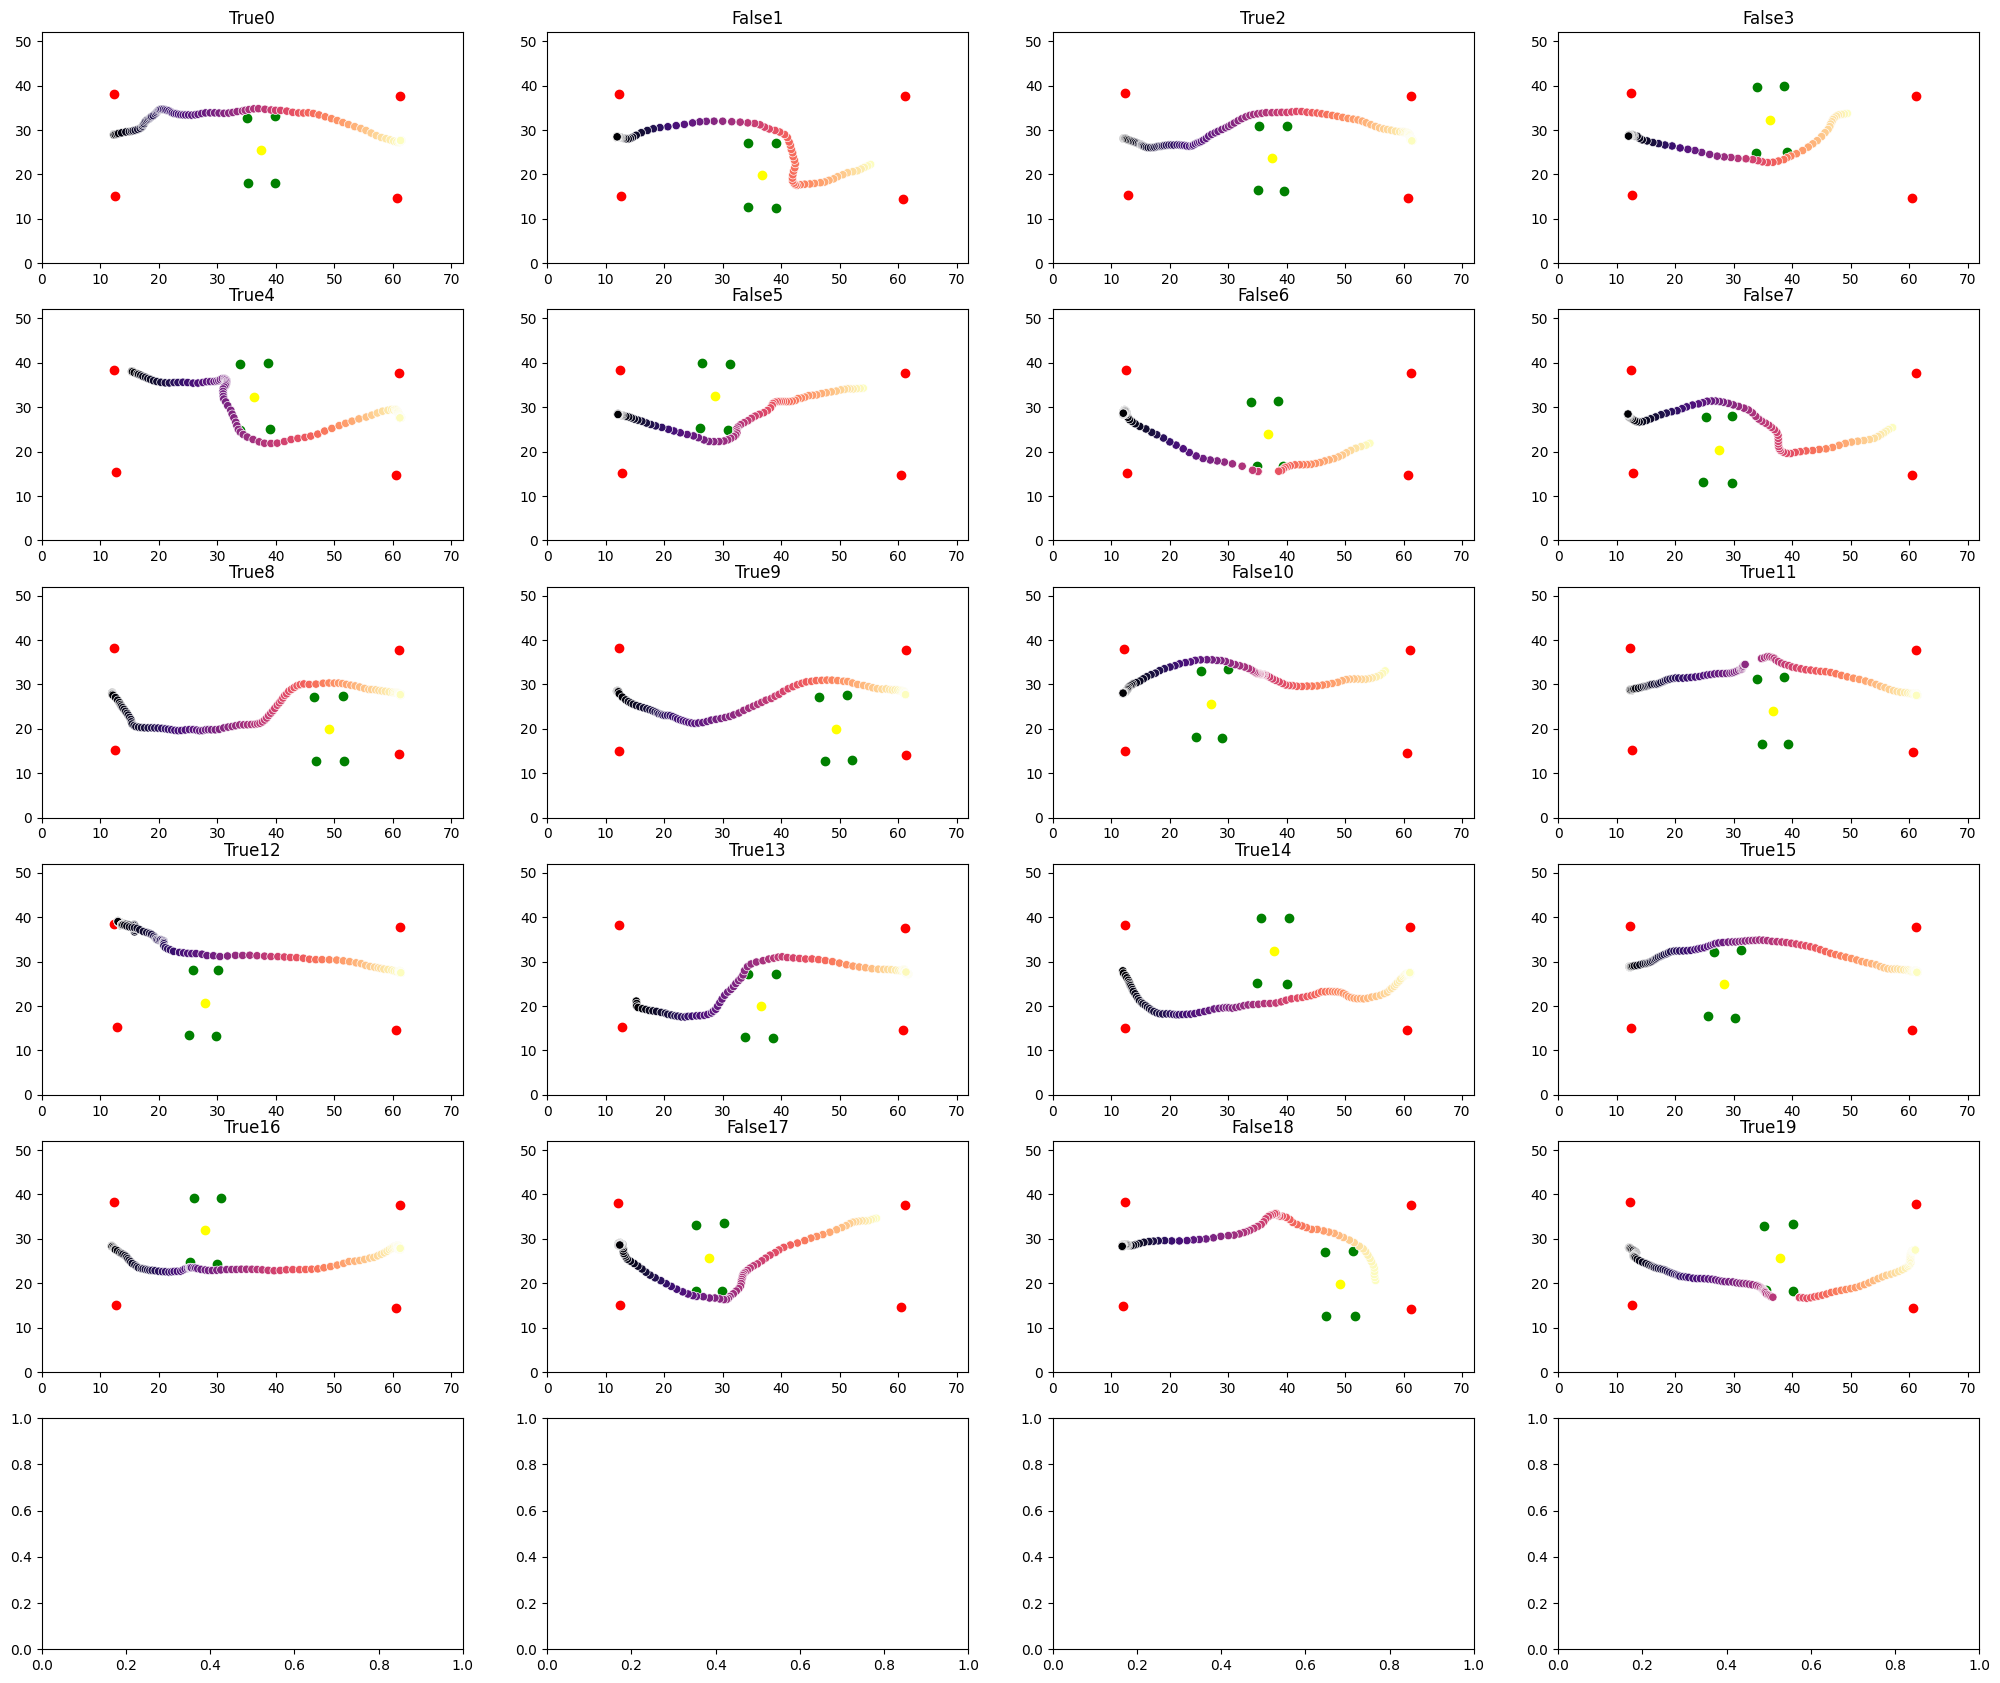

In [40]:
test = df.sample(20)
test = test.reset_index()
plt.subplots(6,4, figsize=(25,21))
for ind, row in test.iterrows():
    plt.subplot(6,4,ind +1)
    plt.xlim([0,72])
    plt.ylim([0,52])
    plt.gca().set_title(str(row['odd'])+str(ind))
    plt.scatter([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')


    plt.scatter([row['median_gt_obstacleTL_x_cm'], row['median_gt_obstacleTR_x_cm'], row['median_gt_obstacleBL_x_cm'], row['median_gt_obstacleBR_x_cm']],
                [row['median_gt_obstacleTL_y_cm'], row['median_gt_obstacleTR_y_cm'], row['median_gt_obstacleBL_y_cm'], row['median_gt_obstacleBR_y_cm']],color='green')
    
   
    
    
    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='yellow')
    

   
    sns.scatterplot(x=row['gt_interp_nose_x_cm'],y=row['gt_interp_nose_y_cm'],hue = row['gt_interp_nose_x_cm'], palette ='magma',legend=False) 

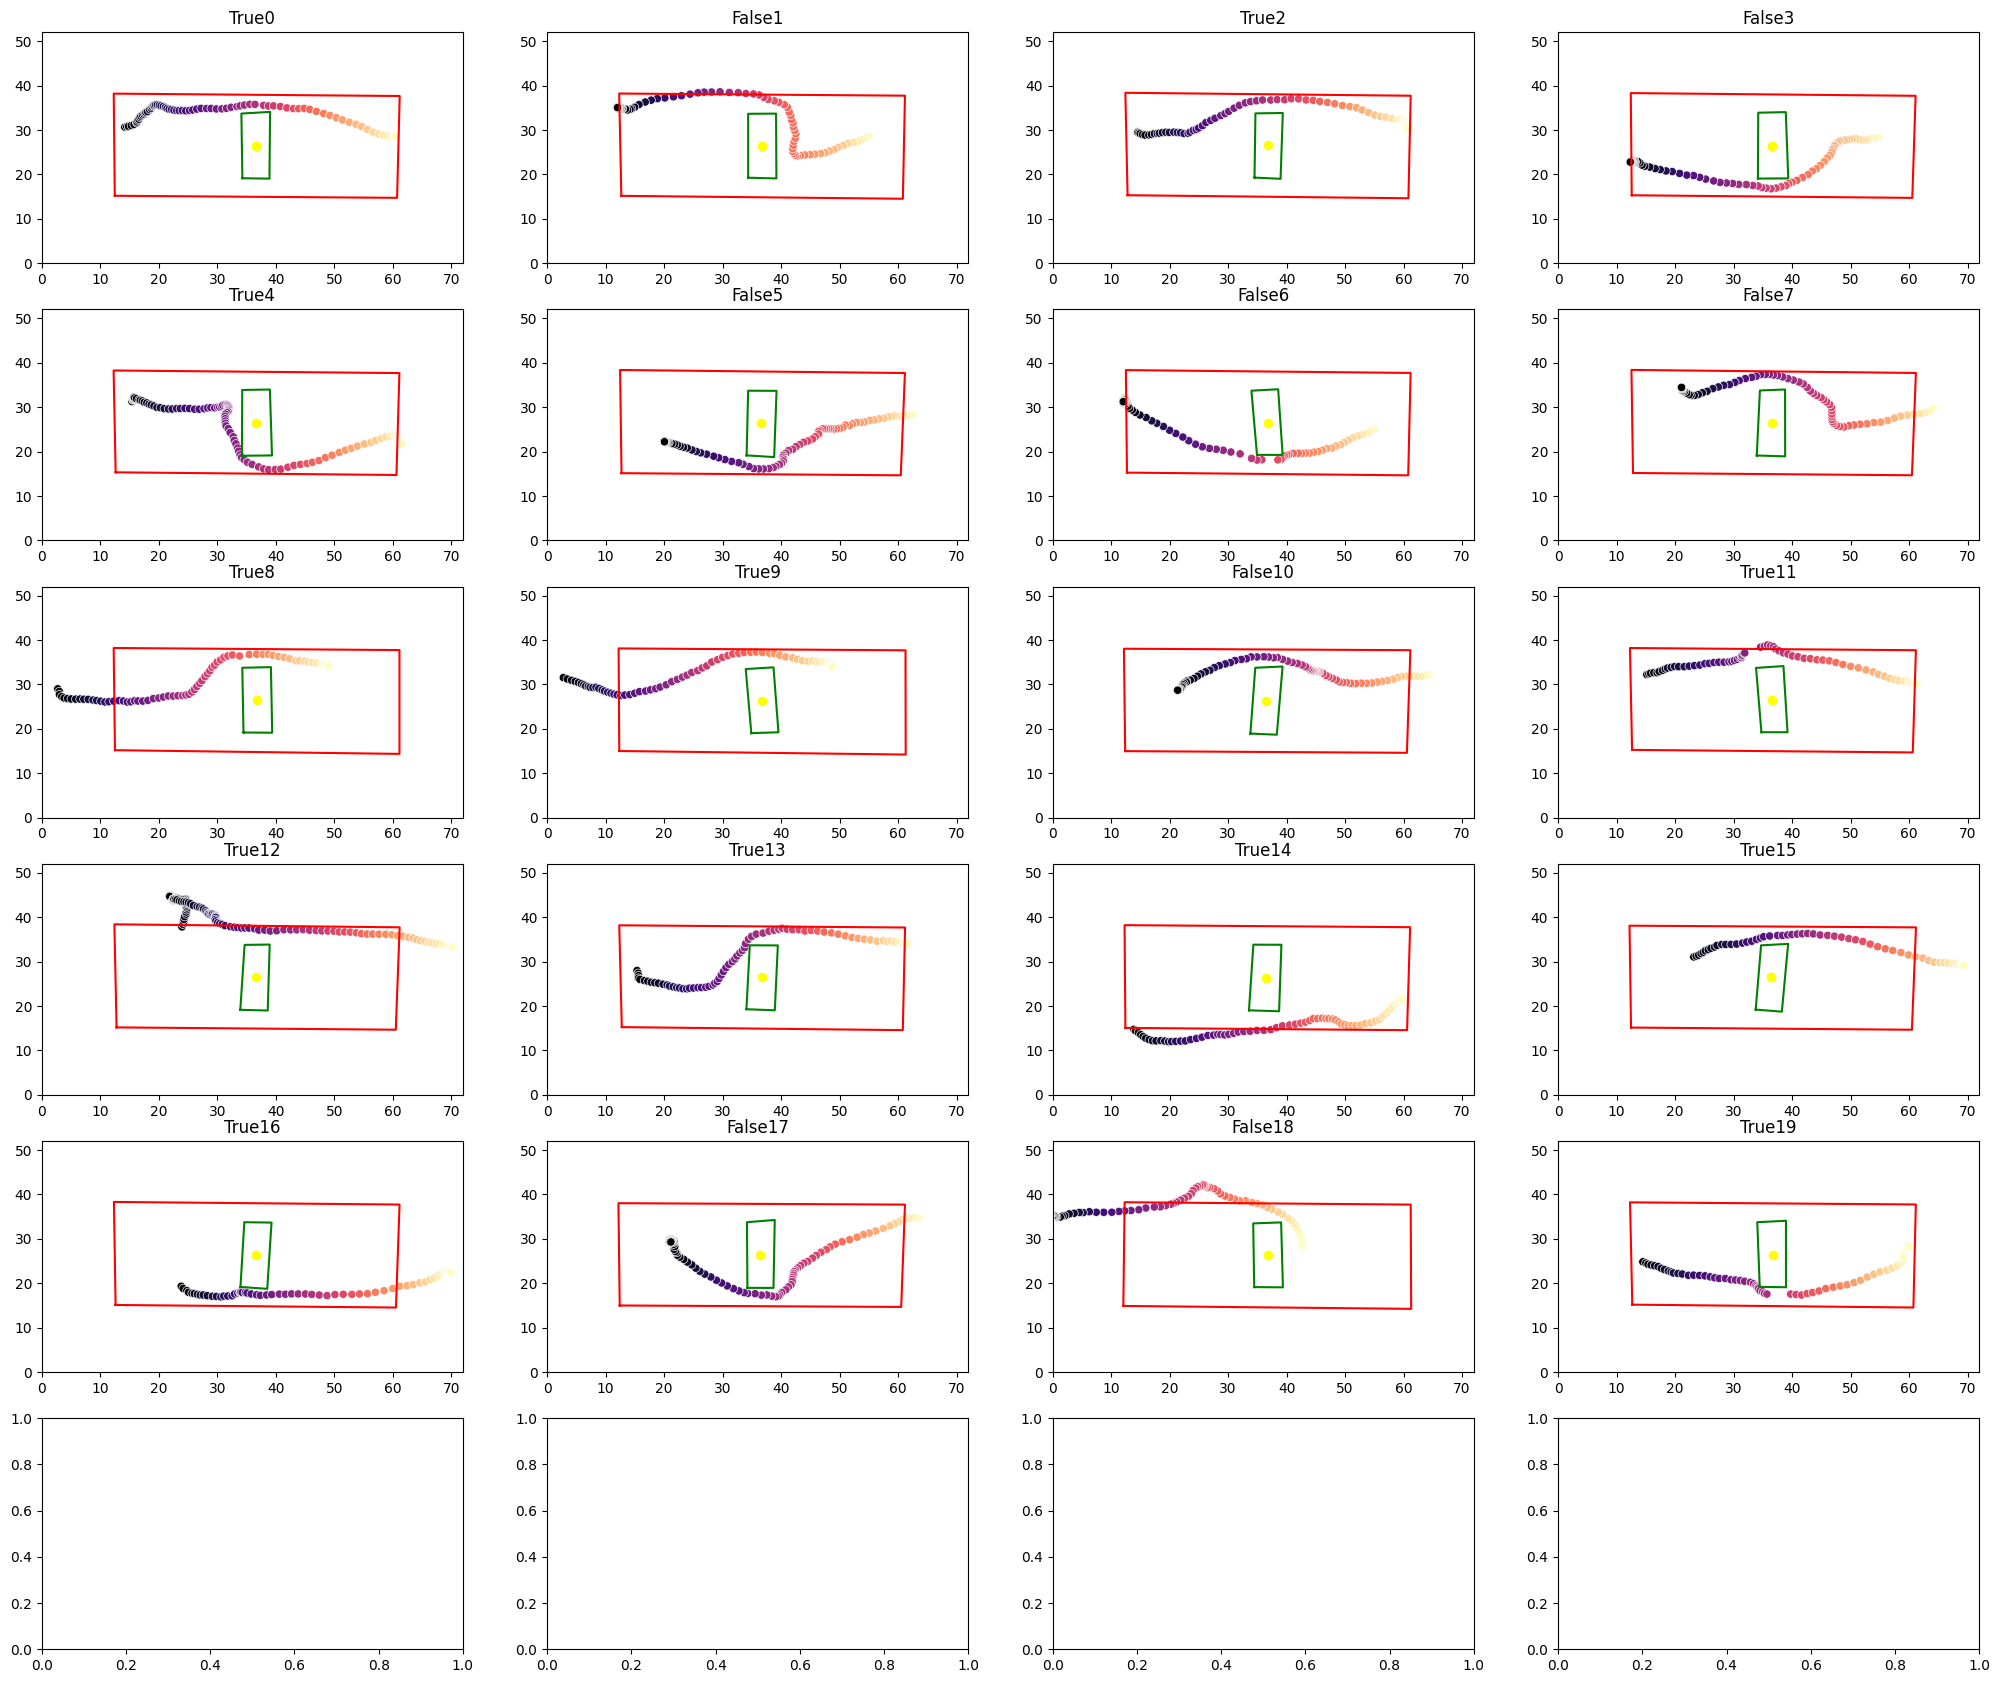

In [71]:
plt.subplots(6,4, figsize=(25,21))
for ind, row in test.iterrows():
    plt.subplot(6,4,ind +1)
    plt.xlim([0,72])
    plt.ylim([0,52])
    plt.gca().set_title(str(row['odd'])+str(ind))
    plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


    plt.plot([row['recen_median_gt_obstacleTL_x_cm'], row['recen_median_gt_obstacleTR_x_cm'], row['recen_median_gt_obstacleBR_x_cm'], row['recen_median_gt_obstacleBL_x_cm'],row['recen_median_gt_obstacleTL_x_cm']],
            [row['recen_median_gt_obstacleTL_y_cm'], row['recen_median_gt_obstacleTR_y_cm'], row['recen_median_gt_obstacleBR_y_cm'],row['recen_median_gt_obstacleBL_y_cm'],row['recen_median_gt_obstacleTL_y_cm']],color='green')
    
   
    
    
    plt.scatter(row['recen_gt_obstacle_cen_x_cm'],row['recen_gt_obstacle_cen_y_cm'],color='yellow')
    

   
    sns.scatterplot(x=row['recen_gt_nose_x_cm'],y=row['recen_gt_nose_y_cm'],hue = row['recen_gt_nose_x_cm'], palette ='magma',legend=False) 

In [3]:
df= pd.read_hdf(r'C:\Users\nlab\obstacle_avoidance\recordings\test\101422\J20LT\oa\raw_J20LT_101422_oa.h5')


(0.0, 72.0)

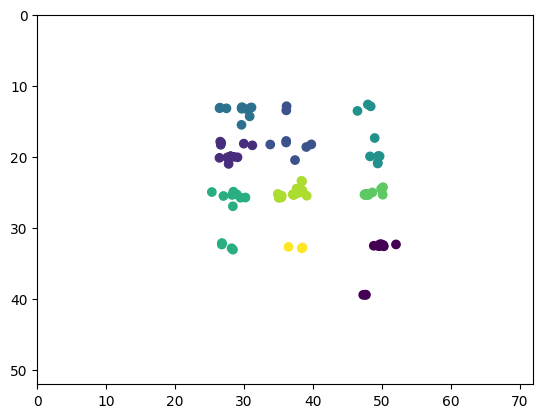

In [4]:
kmeans_input = np.vstack([df['gt_obstacle_cen_x_cm'].values, df['gt_obstacle_cen_y_cm'].values])

kmeans_input = np.transpose(kmeans_input)

labels = KMeans(n_clusters=9).fit(kmeans_input).labels_
df['obstacle_cluster'] = labels



plt.scatter(df['gt_obstacle_cen_x_cm'], df['gt_obstacle_cen_y_cm'], c=labels)
plt.ylim([52, 0]); plt.xlim([0, 72])

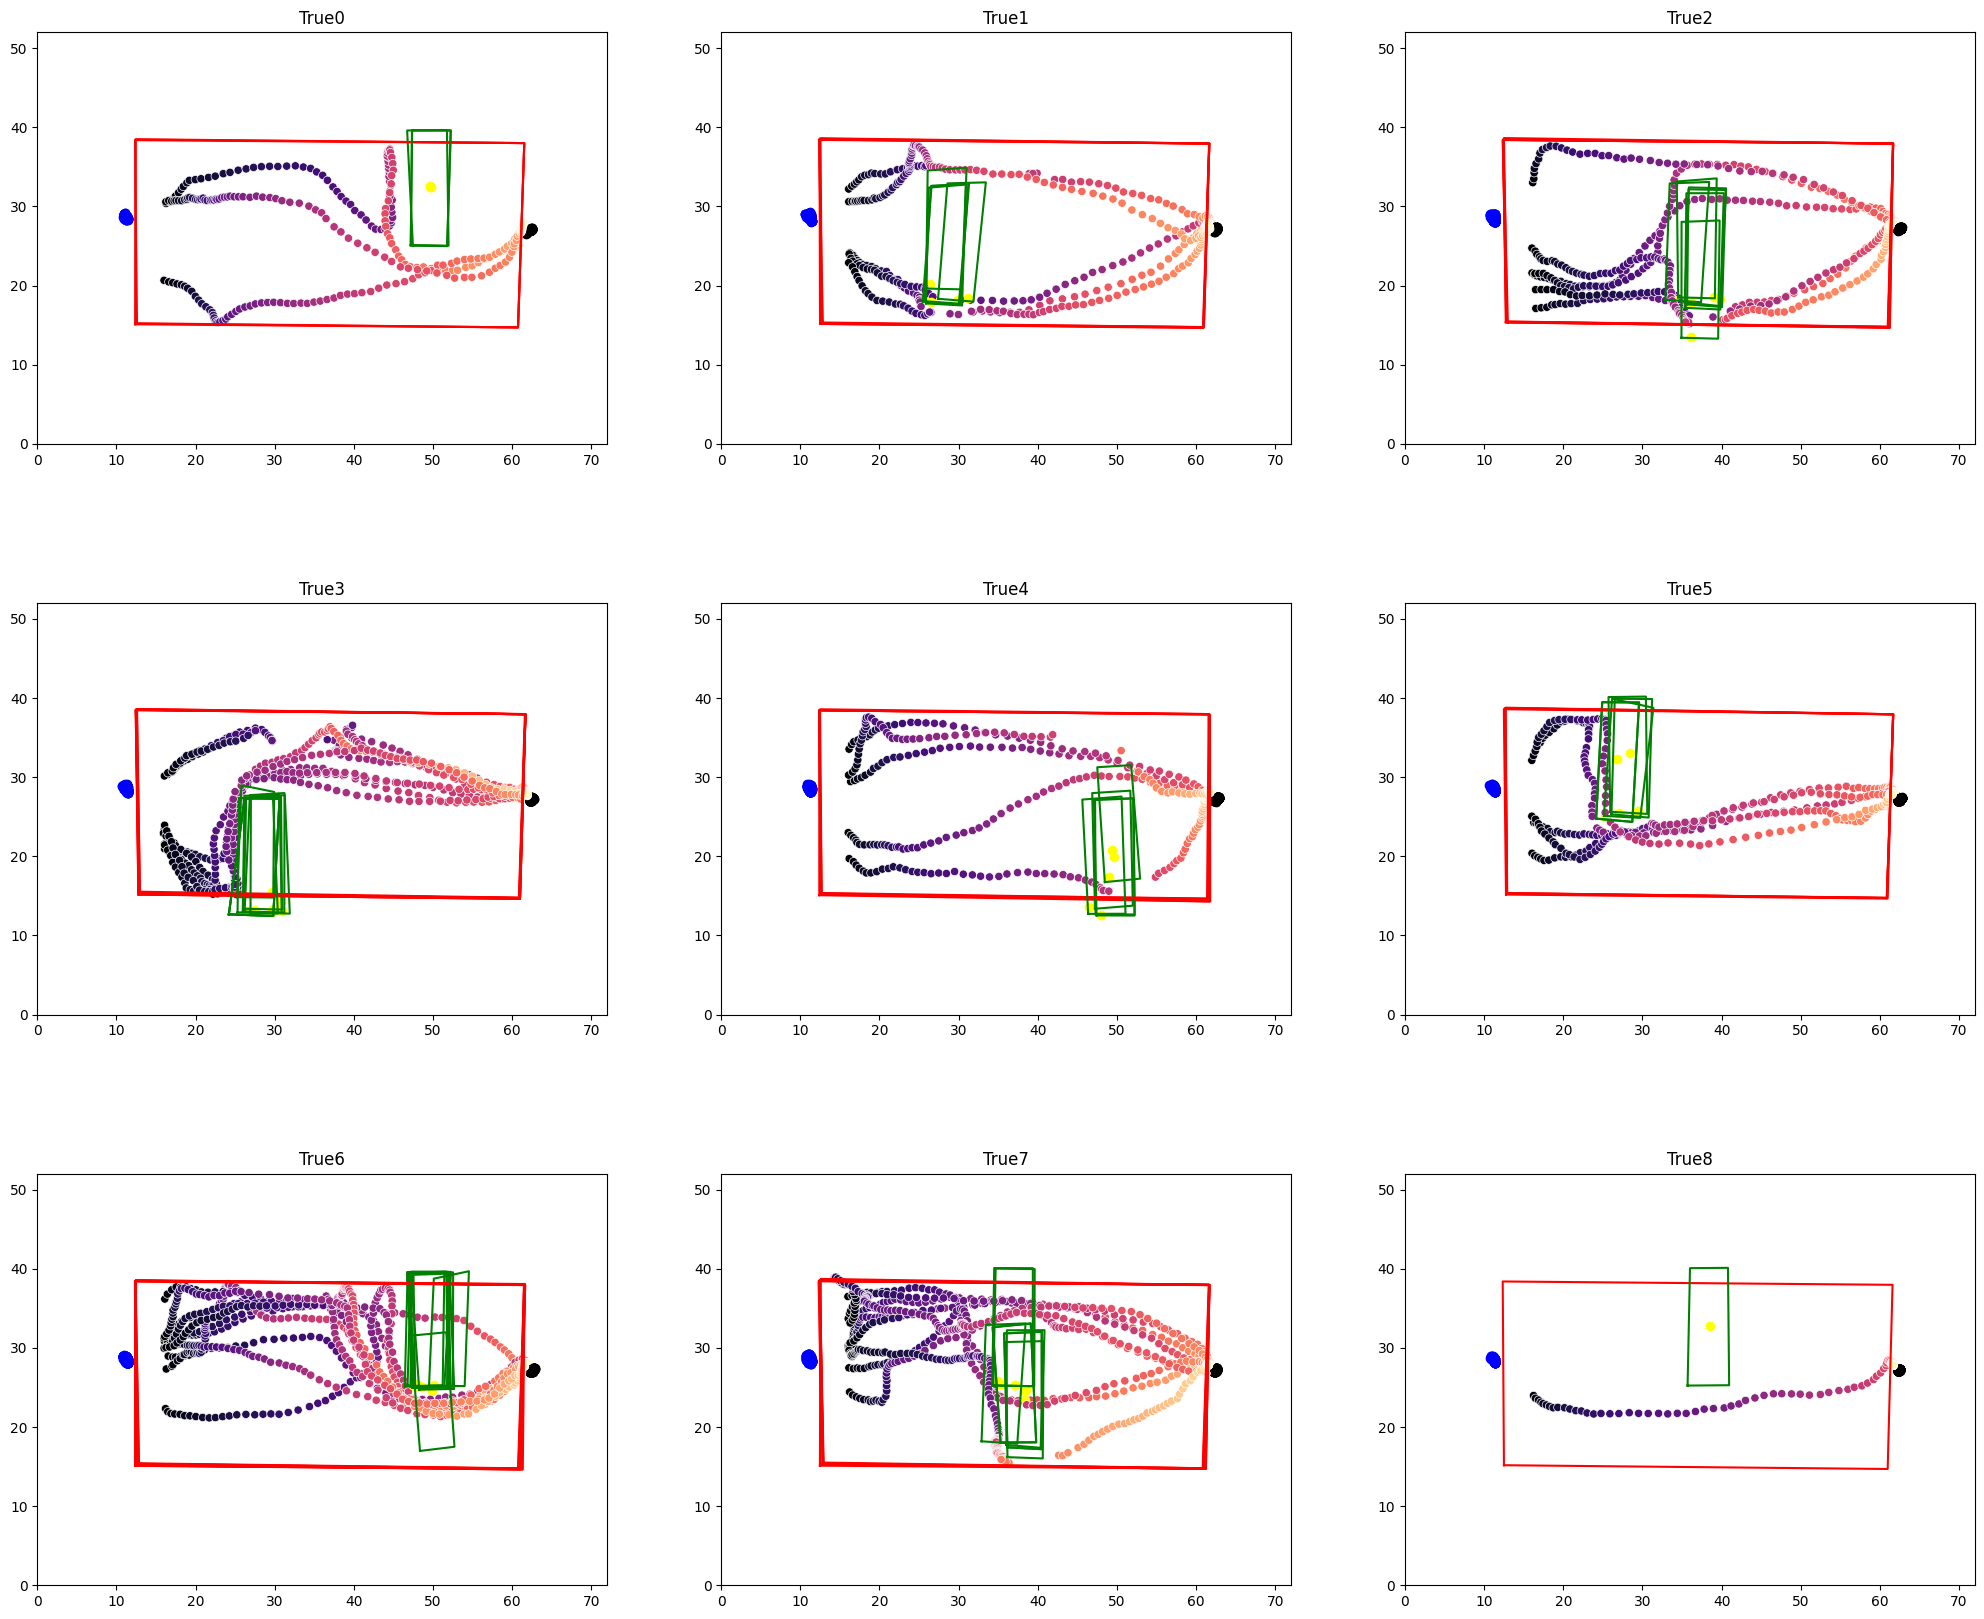

In [5]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(df['obstacle_cluster'].unique()):
    x=df.loc[df['obstacle_cluster']==cluster_name]
    for i, row in x.iterrows():
        if row['odd'] == True:
            plt.subplot(3,3,cluster_name+1)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_title(str(row['odd'])+str(row['obstacle_cluster']))
    
            plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


            plt.plot([row['median_gt_obstacleTL_x_cm'], row['median_gt_obstacleTR_x_cm'], row['median_gt_obstacleBR_x_cm'], row['median_gt_obstacleBL_x_cm'],row['median_gt_obstacleTL_x_cm']],
                [row['median_gt_obstacleTL_y_cm'], row['median_gt_obstacleTR_y_cm'], row['median_gt_obstacleBR_y_cm'], row['median_gt_obstacleBL_y_cm'],row['median_gt_obstacleTL_y_cm']],color='green')
    
   
    
    
            plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='yellow')
            plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
            plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
            sns.scatterplot(x=row['gt_nose_x_cm'],y=row['gt_nose_y_cm'],hue = enumerate(row['gt_nose_x_cm']), palette ='magma',legend=False) 
            #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
            plt.ylim([0,52]); plt.xlim([0, 72])

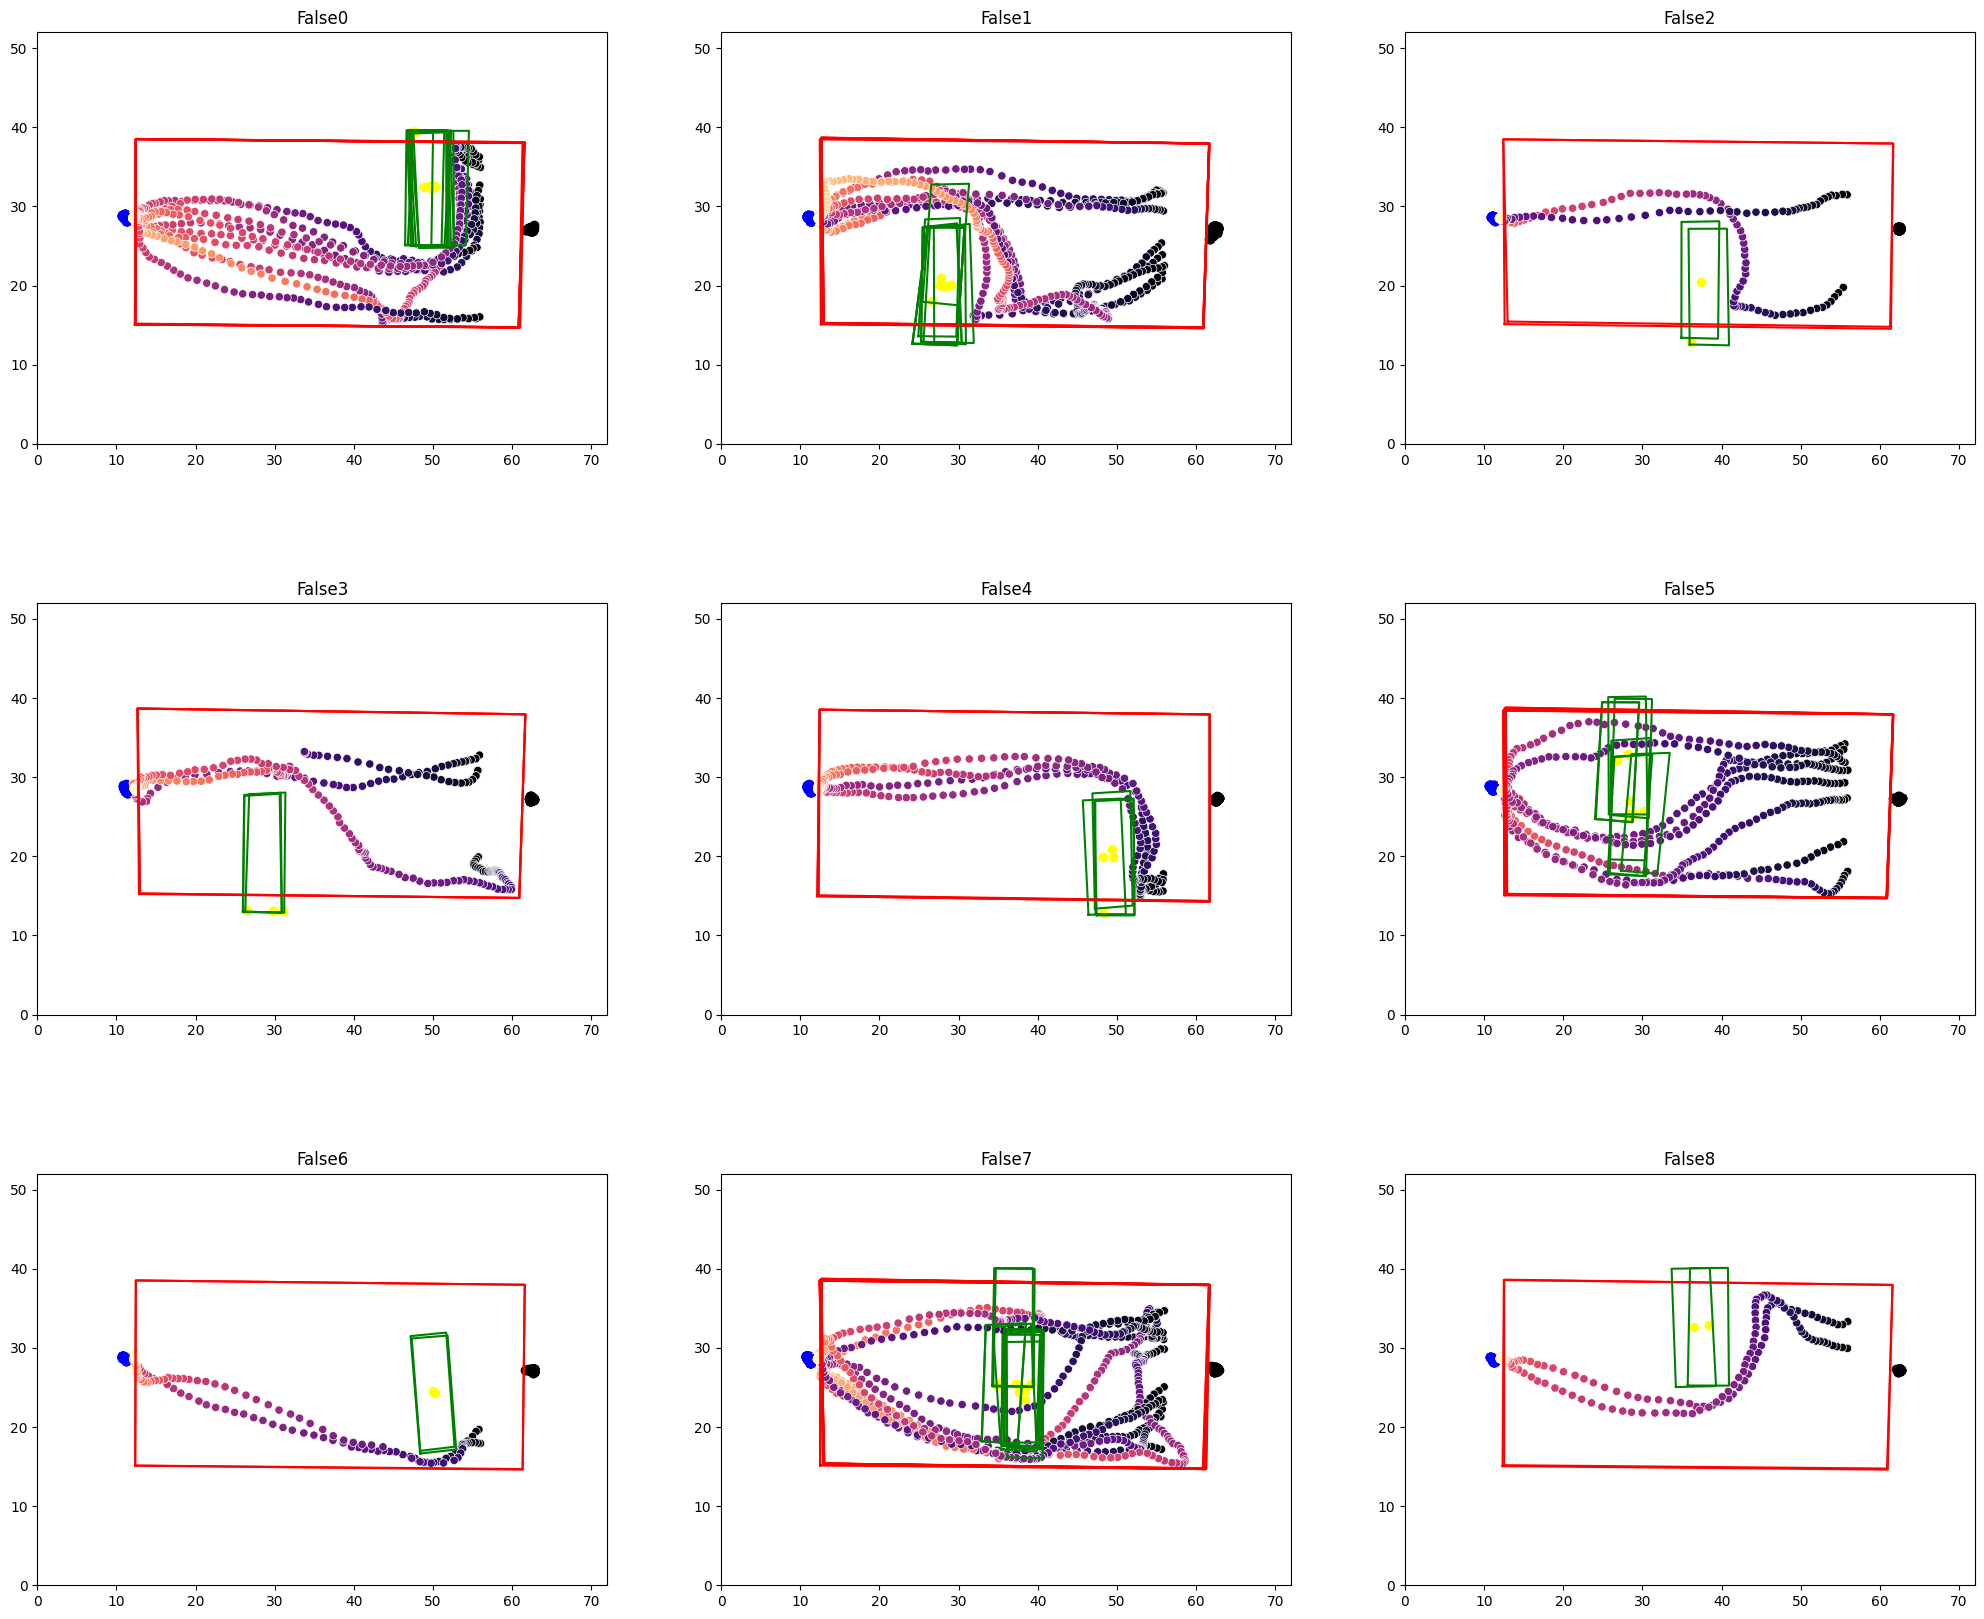

In [6]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(df['obstacle_cluster'].unique()):
    x=df.loc[df['obstacle_cluster']==cluster_name]
    for i, row in x.iterrows():
        if row['odd'] == False:
            plt.subplot(3,3,cluster_name+1)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_title(str(row['odd'])+str(row['obstacle_cluster']))
    
            plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


            plt.plot([row['median_gt_obstacleTL_x_cm'], row['median_gt_obstacleTR_x_cm'], row['median_gt_obstacleBR_x_cm'], row['median_gt_obstacleBL_x_cm'],row['median_gt_obstacleTL_x_cm']],
                [row['median_gt_obstacleTL_y_cm'], row['median_gt_obstacleTR_y_cm'], row['median_gt_obstacleBR_y_cm'], row['median_gt_obstacleBL_y_cm'],row['median_gt_obstacleTL_y_cm']],color='green')
    
   
    
    
            plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='yellow')
            plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
            plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
            sns.scatterplot(x=row['gt_nose_x_cm'],y=row['gt_nose_y_cm'],hue = enumerate(row['gt_nose_x_cm']), palette ='magma',legend=False) 
            #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
            plt.ylim([0,52]); plt.xlim([0, 72])

In [ ]:
plt.subplots(6,4, figsize=(25,21))
for ind, row in test.iterrows():
    plt.subplot(6,4,ind +1)
    plt.xlim([0,72])
    plt.ylim([0,52])
    plt.gca().set_title(str(row['odd'])+str(ind))
    #plt.scatter([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')

    plt.scatter([row['obstacleTL_x_cm_fh'], row['obstacleTR_x_cm_fh'], row['obstacleBL_x_cm_fh'], row['obstacleBR_x_cm_fh']],
                [row['obstacleTL_y_cm_fh'], row['obstacleTR_y_cm_fh'], row['obstacleBL_y_cm_fh'], row['obstacleBR_y_cm_fh']],color='blue')

    plt.scatter([row['obstacleTL_x_cm_lh'], row['obstacleTR_x_cm_lh'], row['obstacleBL_x_cm_lh'], row['obstacleBR_x_cm_lh']],
                [row['obstacleTL_y_cm_lh'], row['obstacleTR_y_cm_lh'], row['obstacleBL_y_cm_lh'], row['obstacleBR_y_cm_lh']],color='green')
    
   
    
    
    plt.scatter(row['obstacle_cen_x_cm_fh'],row['obstacle_cen_y_cm_fh'],color='yellow')
    plt.scatter(row['obstacle_cen_x_cm_lh'],row['obstacle_cen_y_cm_lh'],color='orange')
    plt.scatter(row['arena_cen_x_cm'],row['arena_cen_y_cm'], color ='black')

   
    sns.scatterplot(x=row['nose_x_cm'],y=row['nose_y_cm'],hue = row['nose_x_cm'], palette ='magma',legend=False) 

In [ ]:
plt.subplots(6,4, figsize=(25,21)) 
for ind, row in test.iterrows():
    plt.subplot(6,4,ind +1)
    plt.xlim([0,72])
    plt.ylim([0,52])
    plt.gca().set_title(str(row['odd'])+str(ind))

    #plt.scatter([row['arenaTL_x_cm'] , row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')

    plt.scatter([row['recen_obstacleTL_x_cm_fh'], row['recen_obstacleTR_x_cm_fh'], row['recen_obstacleBL_x_cm_fh'], row['recen_obstacleBR_x_cm_fh']],
                [row['recen_obstacleTL_y_cm_fh'], row['recen_obstacleTR_y_cm_fh'], row['recen_obstacleBL_y_cm_fh'], row['recen_obstacleBR_y_cm_fh']],color='blue')

    plt.scatter([row['recen_obstacleTL_x_cm_lh'], row['recen_obstacleTR_x_cm_lh'], row['recen_obstacleBL_x_cm_lh'], row['recen_obstacleBR_x_cm_lh']],
                [row['recen_obstacleTL_y_cm_lh'], row['recen_obstacleTR_y_cm_lh'], row['recen_obstacleBL_y_cm_lh'], row['recen_obstacleBR_y_cm_lh']],color='green')
    
    
    plt.scatter(row['recen_obstacle_cen_x_cm_fh'],row['recen_obstacle_cen_y_cm_fh'],color='yellow')
    plt.scatter(row['recen_obstacle_cen_x_cm_lh'],row['recen_obstacle_cen_y_cm_lh'],color='orange')

    plt.scatter(row['arena_cen_x_cm'],row['arena_cen_y_cm'], color ='black')

   
    sns.scatterplot(x=row['recen_interp_nose_x_cm'],y=row['recen_interp_nose_y_cm'],hue = row['recen_interp_nose_x_cm'], palette ='magma',legend = False)

    plt.tight_layout()            
                

In [122]:
test = df.sample(1)

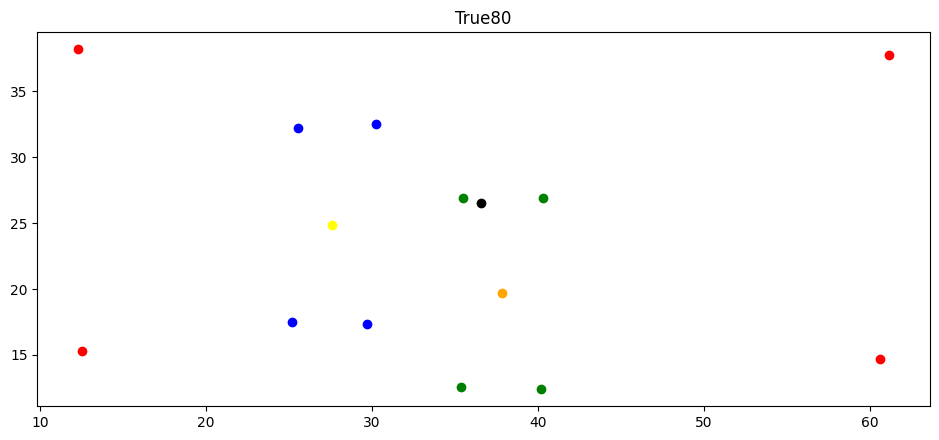

In [132]:
test = df.sample(1)
plt.figure(figsize=(9.5,4.5))
for ind, row in test.iterrows():
    plt.gca().set_title(str(row['odd'])+str(ind))

    plt.scatter([row['arenaTL_x_cm'] , row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')

    plt.scatter([row['obstacleTL_x_cm_fh'], row['obstacleTR_x_cm_fh'], row['obstacleBL_x_cm_fh'], row['obstacleBR_x_cm_fh']],
                [row['obstacleTL_y_cm_fh'], row['obstacleTR_y_cm_fh'], row['obstacleBL_y_cm_fh'], row['obstacleBR_y_cm_fh']],color='blue')

    plt.scatter([row['obstacleTL_x_cm_lh'], row['obstacleTR_x_cm_lh'], row['obstacleBL_x_cm_lh'], row['obstacleBR_x_cm_lh']],
                [row['obstacleTL_y_cm_lh'], row['obstacleTR_y_cm_lh'], row['obstacleBL_y_cm_lh'], row['obstacleBR_y_cm_lh']],color='green')
    
    
    plt.scatter(row['obstacle_cen_x_cm_fh'],row['obstacle_cen_y_cm_fh'],color='yellow')
    plt.scatter(row['obstacle_cen_x_cm_lh'],row['obstacle_cen_y_cm_lh'],color='orange')

    plt.scatter(row['arena_cen_x_cm'],row['arena_cen_y_cm'], color ='black')

   
    sns.scatterplot(x=row['nose_x_cm'],y=row['nose_y_cm'],hue = row['nose_x_cm'], palette ='magma')

    plt.tight_layout()            
                

In [403]:
odd = df[df['odd']==True]
even = df[df['odd']==False]

In [248]:
odd_pts = odd['nose_x_cm'].to_numpy() 
odd_pts = odd_pts.reshape(-1)

In [402]:
## make serries from multiple objects from df column 
def flatten_column(df,column):
  column_list = []
  for ind, row in df.iterrows(): 
    #pts=
    series = row[column]
    column_list.append(series)
  column_list = list(itertools.chain(*column_list))
  column_list = np.array(column_list)


  return column_list


In [409]:
nose_odd= flatten_column(odd,'nose_x_cm')

In [431]:
nose_odd

array([12.04970143, 12.06467464, 12.11358514, ..., 61.13093089,
       61.14231572, 61.1230928 ])

(array([4630.,  591.,  504.,  320.,  392.,  310.,  271.,  229.,  263.,
        1758.]),
 array([11.73960369, 16.73793033, 21.73625696, 26.7345836 , 31.73291024,
        36.73123687, 41.72956351, 46.72789015, 51.72621678, 56.72454342,
        61.72287005]),
 <BarContainer object of 10 artists>)

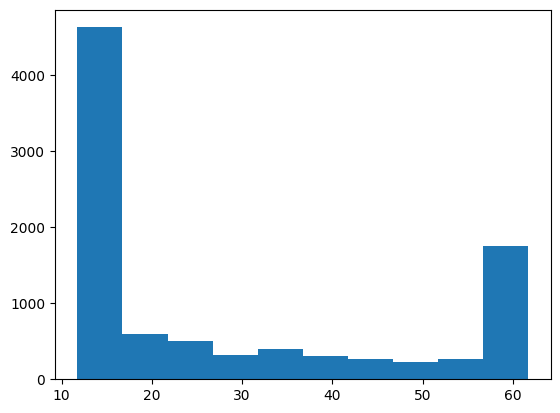

In [410]:
plt.hist(nose_odd)

In [411]:
nose_even= flatten_column(even,'nose_x_cm')

ValueError: 'list' argument must have no negative elements

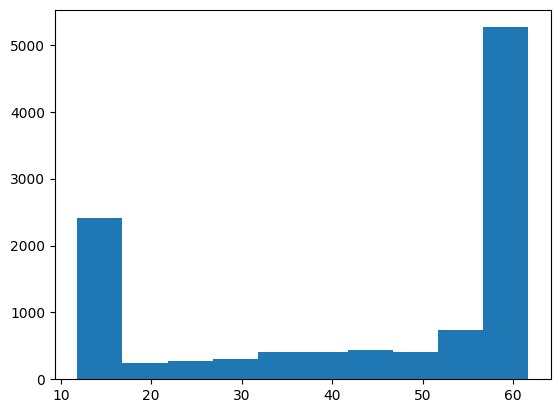

In [433]:
plt.hist(nose_even)
#np.bincount(nose_even.astype('int64')).argmax

In [415]:
print(len(df.at[1,'obstacleTL_x_cm']),len(df.at[1,'nose_x_cm']),df.at[1,'odd'])

208 208 False


In [420]:
test_df = df.iloc[[1]]

In [421]:
test_df

,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,...,recen_obstacle_cen_x_cm_fh,recen_obstacle_cen_y_cm_fh,recen_obstacle_cen_x_cm_lh,recen_obstacle_cen_y_cm_lh,recen_nose_x,recen_nose_y,recen_nose_x_cm,recen_nose_y_cm,recen_interp_nose_x_cm,recen_interp_nose_y_cm
1,56552.3456,56555.815129,"[56552.354675, 56552.371827, 56552.388313, 565...","[[406, 407, 408, 409, 410, 411, 412, 413, 414,...","[573.2466430664062, 573.4270629882812, 572.854...","[258.6023254394531, 257.80621337890625, 258.49...","[0.9999932050704956, 0.9999903440475464, 0.999...","[553.0242309570312, 552.2793579101562, 552.894...","[258.2682189941406, 258.8601989746094, 259.044...","[0.9999985694885254, 0.9999986886978149, 0.999...",...,36.65762,26.505477,36.658722,26.501843,"[572.360164566105, 572.54058448798, 571.967769...","[259.66424960539473, 258.86813754484785, 259.5...","[60.4601239944089, 60.47943182527588, 60.41813...","[28.736528552772736, 28.651331769310794, 28.72...","[60.4601239944089, 60.476967487447546, 60.4177...","[28.736528552772736, 28.65429750863974, 28.724..."


In [428]:
test_df['nose_x_cm'].iteritems

<bound method Series.iteritems of 1    [61.34660249471013, 61.36591032557711, 61.3046...
Name: nose_x_cm, dtype: object>

In [337]:
##create list of columns from df based on list of keys 
#keys as [] exp ['nose','leftear','rightear','spine','midspine']
def columns_list(df,keys): 
  columns_list = []
  for key in keys:
    columns = [col for col in df.columns if key in col]
    columns_list.append(columns)
  columns_list = list(itertools.chain(*columns_list))
  columns_list = np.array(columns_list)


  return columns_list

In [334]:
columns_list = []
for key in keys:
    columns = [col for col in df.columns if key in col]
    columns_list.append(columns)
    column_list = list(itertools.chain(*column_list))
    column_list = np.array(column_list)

TypeError: type object argument after * must be an iterable, not function

In [338]:
a = columns_list(df,['nose','leftear','rightear','spine','midspine'])

In [325]:
list = [item for item in list if 'likelihood' not in item]

In [309]:
a_o = ['arena','obstacle']
columns_list = []
for poi in a_o: 
    columns = [col for col in df.columns if poi in col]
    columns_list.append(columns)
columns_list = list(itertools.chain(*columns_list))


In [302]:
c = flatten_column(df,'interp_nose_x_cm')

In [305]:
np.array(c).shape

(10500,)

In [306]:
len(df)

105

(array([194.,  21.,  11.,   5.,   6.,   8.,   9.,   7.,   5.,  27.]),
 array([12.00097464, 16.93629641, 21.87161818, 26.80693996, 31.74226173,
        36.67758351, 41.61290528, 46.54822706, 51.48354883, 56.41887061,
        61.35419238]),
 <BarContainer object of 10 artists>)

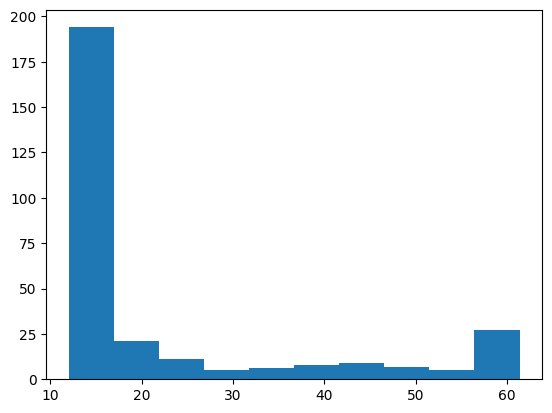

In [228]:
plt.hist(df2.at[14,'nose_x_cm'])

In [69]:
df= pd.read_hdf(r'C:\Users\nlab\obstacle_avoidance\recordings\101322\J20LT\oa\raw_J20LT_101322_oa.h5')
df = df.reset_index()
df2 = df.iloc[[1,14]]

In [3]:
df2['odd']

1     False
14     True
Name: odd, dtype: object

In [16]:
test = df.sample(10)
keys = ['nose','leftear','rightear','spine','midspine','obstalce']
test_list = columns_list(test,keys)

In [ ]:
test_list = [col for col in test_list if 'likelihood' not in col]
test_list
for ind, row in test.iterrows():
    for col in test_list:
        col_len =  len(row[col])
        print(ind,col,col_len)

In [38]:
df2

,index,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,...,obstacleTR_y_cm_lind,obstacleBR_x_cm_lind,obstacleBR_y_cm_lind,obstacleBL_x_cm_lind,obstacleBL_y_cm_lind,obstacle_x_lind,obstacle_x_cm_lind,obstacle_y_lind,obstacle_y_cm_lind,gt_midspine_y_cm
1,1,56552.345600,56555.815129,"[56552.354675, 56552.371827, 56552.388313, 565...","[[406, 407, 408, 409, 410, 411, 412, 413, 414,...","[573.2466430664062, 573.4270629882812, 572.854...","[258.6023254394531, 257.80621337890625, 258.49...","[0.9999932050704956, 0.9999903440475464, 0.999...","[553.0242309570312, 552.2793579101562, 552.894...","[258.2682189941406, 258.8601989746094, 259.044...",...,18.055350,39.984973,33.088831,35.032733,32.685640,350.973907,37.559848,238.270298,25.498751,"[18.449643180556627, 18.331028369465052, 18.22..."
14,14,56602.316992,56606.159283,"[56602.322713, 56602.338598, 56602.3552, 56602...","[3403, 3404, 3405, 3406, 3407, 3408, 3409, 341...","[114.40145874023438, 114.34269714355469, 114.6...","[270.16424560546875, 269.72125244140625, 269.5...","[0.9999997615814209, 0.9999997615814209, 0.999...","[131.69277954101562, 131.94320678710938, 132.7...","[261.6601867675781, 261.91351318359375, 261.95...",...,24.904367,31.249153,39.896827,26.436390,39.897294,267.939381,28.673819,303.664394,32.496970,"[25.684506546376674, 25.915571836563647, 26.30..."


In [70]:
## get index of obstacle,bodyparts after mouse reaches a ceartin x postion

# get list of columns need for re in
keys = ['nose','leftear','rightear','spine','midspine','obstacle']
keys_list = columns_list(df2,keys)
keys_list= [col for col in keys_list if 'likelihood' not in col]
keys_list= [col for col in keys_list if 'lind' not in col]



# check if odd or even trial
#  get first index when nose crosses a distance thresh hold
##odd tiral at 15 cm even at 55 cm 



for ind, row in df2.iterrows(): 
    if row['odd'] == True:
        nose_list = row['nose_x_cm'] 
        odd_ind = np.argmax(nose_list>16)
        for key in keys_list:
            df2.at[ind,'gt_' + key] = row[key][odd_ind:]
        #use odd_ind to index into obstacle 
        # iterate over columns list  

        #create gt_obstacle points
    else: 
        nose_list = row['nose_x_cm']
        even_ind = np.argmax(nose_list<56)
        for key in keys_list:
            df2.at[ind,'gt_' + key] = row[key][even_ind:]

##  median point at gt obstacle 
obstacle_cols = columns_list(df2,['obstacle'])
obstacle_cols = [col for col in obstacle_cols if 'gt_' in col]
for ind, row in df2.iterrows():
    # calculate median of each corner
    for col in obstacle_cols:
        df2.at[ind,'median_'+ col]= np.nanmedian(row[col])
        
       
        

## get obstacle center        

    
for ind, row in df2.iterrows():
  
  xvals = np.stack([row['gt_obstacleTL_x'], row['gt_obstacleTR_x'], row['gt_obstacleBL_x'], row['gt_obstacleBR_x']])
  xvals_cm = np.stack([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBL_x_cm'], row['gt_obstacleBR_x_cm']])
  df2.at[ind,'gt_obstacle_cen_x' ] = np.nanmedian(xvals)
  df2.at[ind,'gt_obstacle_cen_x_cm' ] = np.nanmedian(xvals_cm)
  
  yvals = np.stack([row['gt_obstacleTL_y'], row['gt_obstacleTR_y'], row['gt_obstacleBL_y'], row['gt_obstacleBR_y']])
  yvals_cm = np.stack([row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBL_y_cm'], row['gt_obstacleBR_y_cm']])
  df2.at[ind,'gt_obstacle_cen_y' ] = np.nanmedian(yvals)
  df2.at[ind,'gt_obstacle_cen_y_cm' ] = np.nanmedian(yvals_cm)
  

     

In [77]:
df2

,index,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,...,median_gt_obstacleTR_x_cm,median_gt_obstacleTR_y_cm,median_gt_obstacleBR_x_cm,median_gt_obstacleBR_y_cm,median_gt_obstacleBL_x_cm,median_gt_obstacleBL_y_cm,gt_obstacle_cen_x,gt_obstacle_cen_x_cm,gt_obstacle_cen_y,gt_obstacle_cen_y_cm
1,1,56552.345600,56555.815129,"[56552.354675, 56552.371827, 56552.388313, 565...","[[406, 407, 408, 409, 410, 411, 412, 413, 414,...","[573.2466430664062, 573.4270629882812, 572.854...","[258.6023254394531, 257.80621337890625, 258.49...","[0.9999932050704956, 0.9999903440475464, 0.999...","[553.0242309570312, 552.2793579101562, 552.894...","[258.2682189941406, 258.8601989746094, 259.044...",...,39.869680,18.045304,40.017137,33.097608,35.008051,32.701729,351.070648,37.570201,238.677185,25.542294
14,14,56602.316992,56606.159283,"[56602.322713, 56602.338598, 56602.3552, 56602...","[3403, 3404, 3405, 3406, 3407, 3408, 3409, 341...","[114.40145874023438, 114.34269714355469, 114.6...","[270.16424560546875, 269.72125244140625, 269.5...","[0.9999997615814209, 0.9999997615814209, 0.999...","[131.69277954101562, 131.94320678710938, 132.7...","[261.6601867675781, 261.91351318359375, 261.95...",...,30.861517,24.914445,31.244465,39.894170,26.430513,39.871335,268.368355,28.719726,306.059013,32.753233


In [82]:
df2.columns.values

array(['index', 'first_poke', 'second_poke', 'trial_timestamps',
       'trial_vidframes', 'nose_x', 'nose_y', 'nose_likelihood',
       'leftear_x', 'leftear_y', 'leftear_likelihood', 'rightear_x',
       'rightear_y', 'rightear_likelihood', 'spine_x', 'spine_y',
       'spine_likelihood', 'midspine_x', 'midspine_y',
       'midspine_likelihood', 'tailbase_x', 'tailbase_y',
       'tailbase_likelihood', 'midtail_x', 'midtail_y',
       'midtail_likelihood', 'tailend_x', 'tailend_y',
       'tailend_likelihood', 'arenaTL_x', 'arenaTL_y',
       'arenaTL_likelihood', 'arenaTR_x', 'arenaTR_y',
       'arenaTR_likelihood', 'arenaBL_x', 'arenaBL_y',
       'arenaBL_likelihood', 'arenaBR_x', 'arenaBR_y',
       'arenaBR_likelihood', 'obstacleTL_x', 'obstacleTL_y',
       'obstacleTL_likelihood', 'obstacleTR_x', 'obstacleTR_y',
       'obstacleTR_likelihood', 'obstacleBR_x', 'obstacleBR_y',
       'obstacleBR_likelihood', 'obstacleBL_x', 'obstacleBL_y',
       'obstacleBL_likelihood', 'leftp

In [79]:
obstacle_cols = columns_list(df2,['obstacle'])
obstacle_cols

array(['obstacleTL_x', 'obstacleTL_y', 'obstacleTL_likelihood',
       'obstacleTR_x', 'obstacleTR_y', 'obstacleTR_likelihood',
       'obstacleBR_x', 'obstacleBR_y', 'obstacleBR_likelihood',
       'obstacleBL_x', 'obstacleBL_y', 'obstacleBL_likelihood',
       'obstacleTL_x_cm', 'obstacleTL_y_cm', 'obstacleTR_x_cm',
       'obstacleTR_y_cm', 'obstacleBR_x_cm', 'obstacleBR_y_cm',
       'obstacleBL_x_cm', 'obstacleBL_y_cm', 'obstacleTL_x_lind',
       'obstacleTL_y_lind', 'obstacleTR_x_lind', 'obstacleTR_y_lind',
       'obstacleBR_x_lind', 'obstacleBR_y_lind', 'obstacleBL_x_lind',
       'obstacleBL_y_lind', 'obstacleTL_x_cm_lind',
       'obstacleTL_y_cm_lind', 'obstacleTR_x_cm_lind',
       'obstacleTR_y_cm_lind', 'obstacleBR_x_cm_lind',
       'obstacleBR_y_cm_lind', 'obstacleBL_x_cm_lind',
       'obstacleBL_y_cm_lind', 'obstacle_x_lind', 'obstacle_x_cm_lind',
       'obstacle_y_lind', 'obstacle_y_cm_lind', 'gt_obstacleTL_x',
       'gt_obstacleTL_y', 'gt_obstacleTR_x', 'gt_obsta

In [87]:
df2 = df2.reset_index()

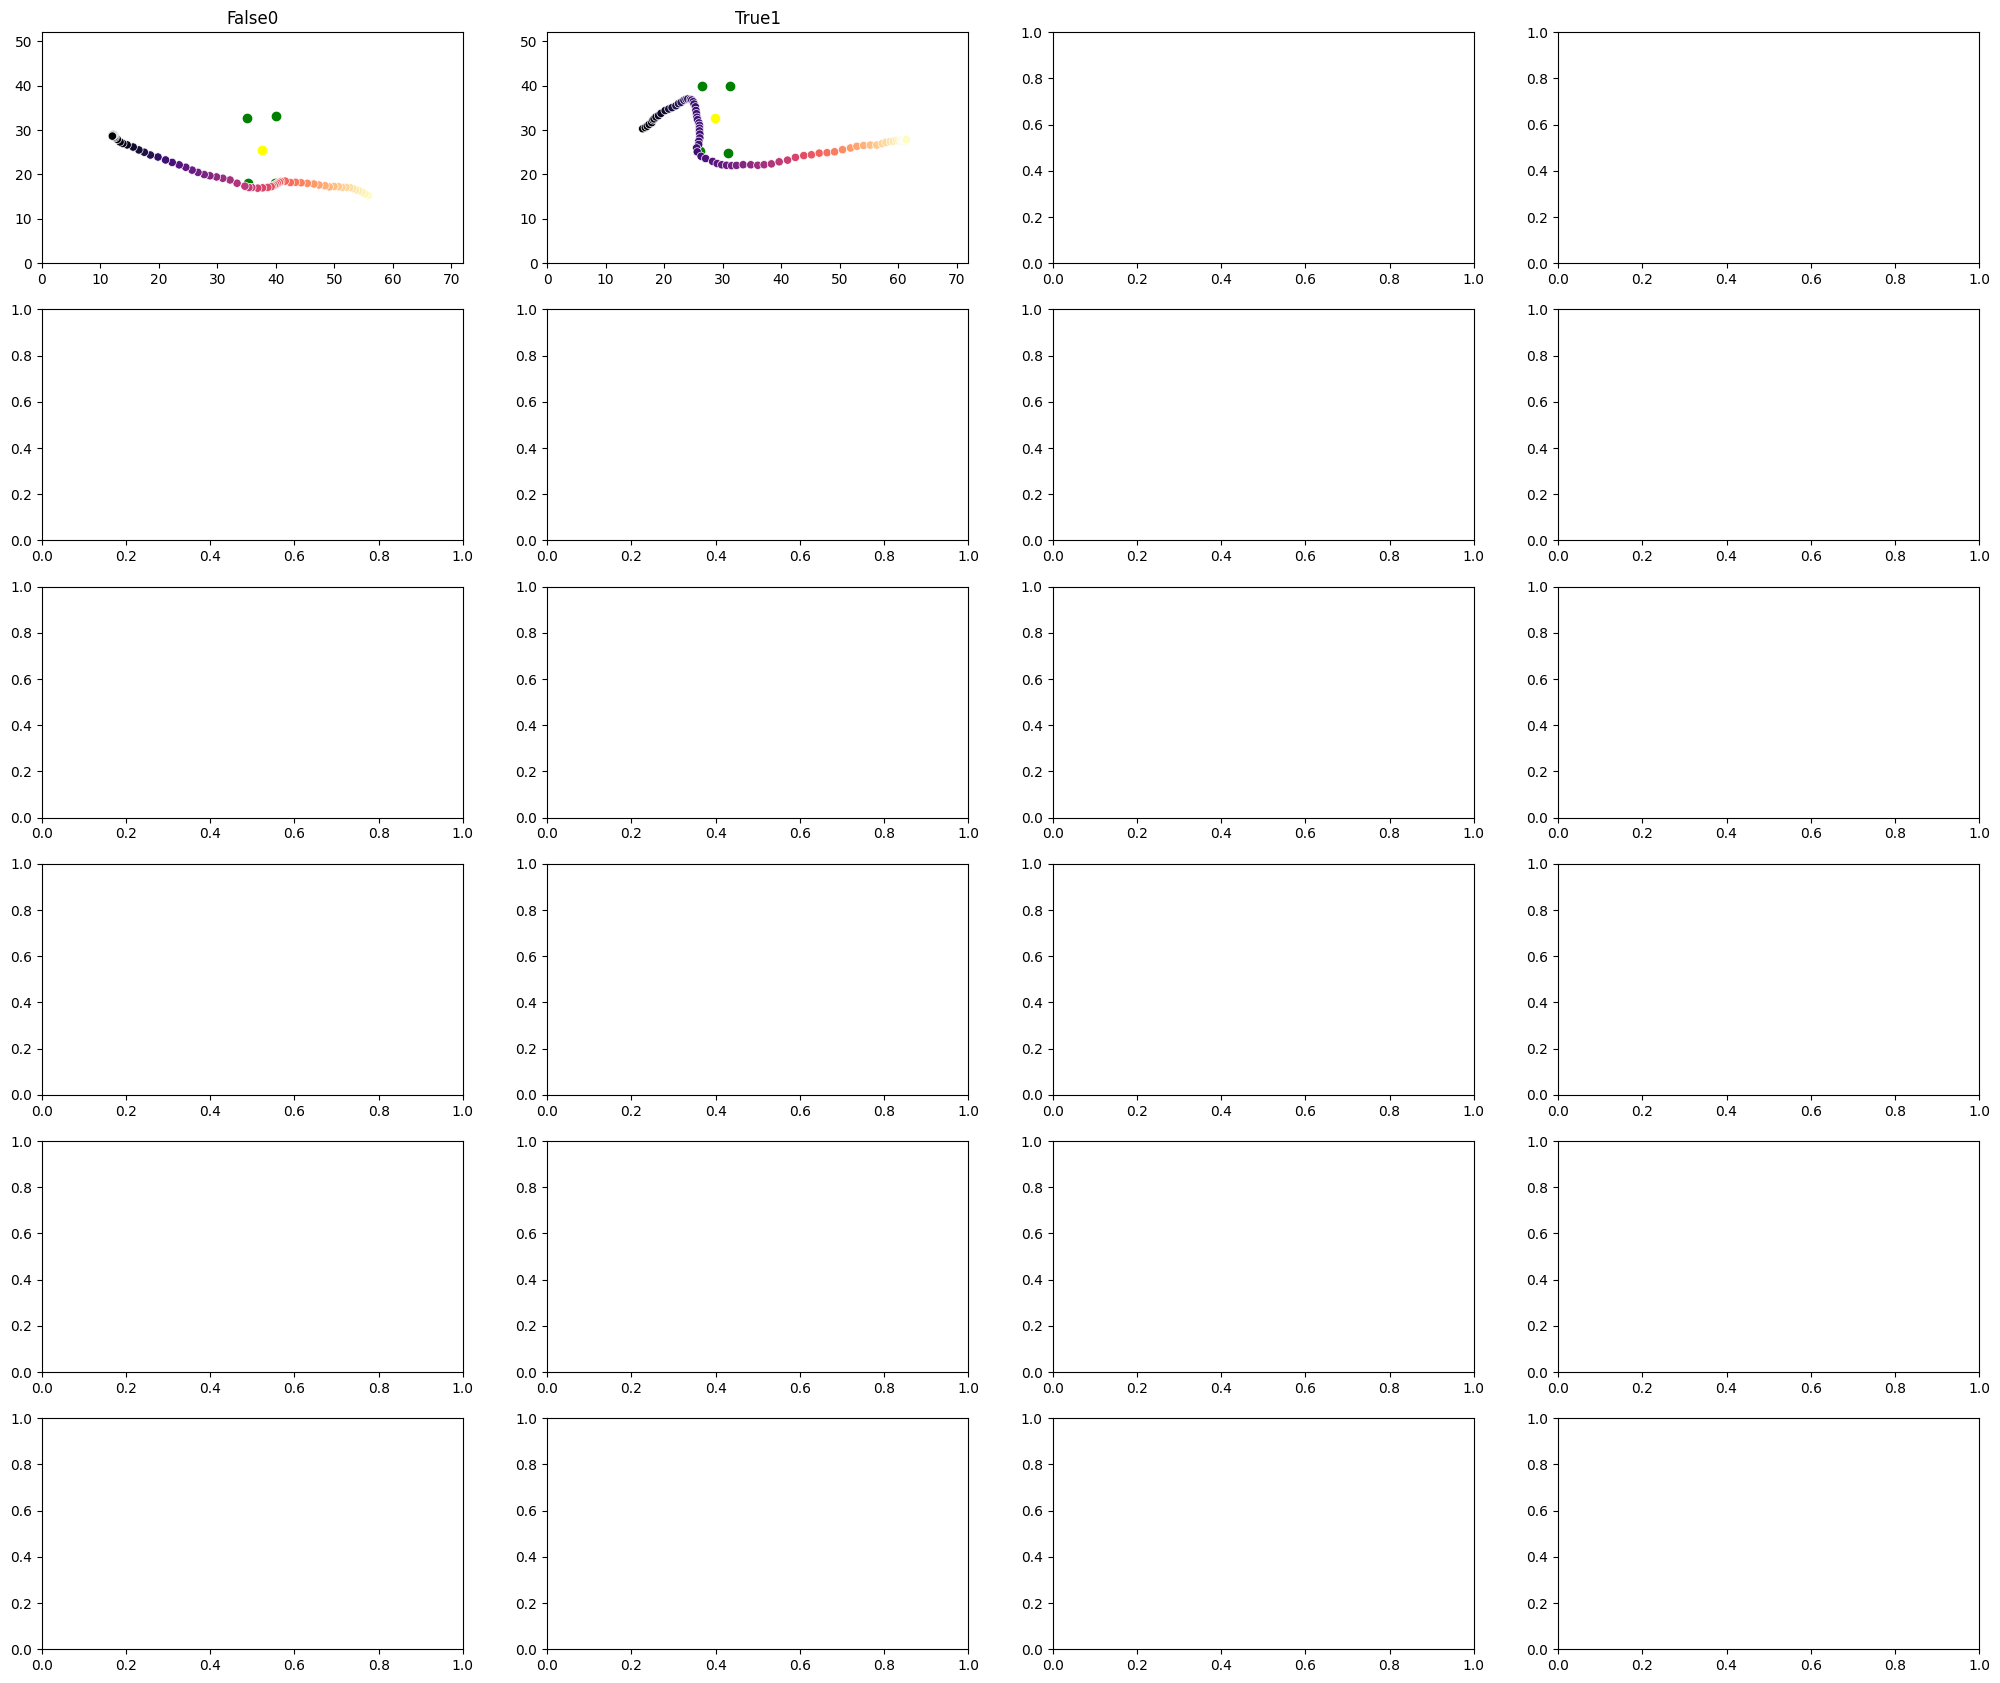

In [88]:
plt.subplots(6,4, figsize=(25,21))
for ind, row in df2.iterrows():
    plt.subplot(6,4,ind +1)
    plt.xlim([0,72])
    plt.ylim([0,52])
    plt.gca().set_title(str(row['odd'])+str(ind))
    #plt.scatter([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')


    plt.scatter([row['median_gt_obstacleTL_x_cm'], row['median_gt_obstacleTR_x_cm'], row['median_gt_obstacleBL_x_cm'], row['median_gt_obstacleBR_x_cm']],
                [row['median_gt_obstacleTL_y_cm'], row['median_gt_obstacleTR_y_cm'], row['median_gt_obstacleBL_y_cm'], row['median_gt_obstacleBR_y_cm']],color='green')
    
   
    
    
    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='yellow')
    

   
    sns.scatterplot(x=row['gt_nose_x_cm'],y=row['gt_nose_y_cm'],hue = row['gt_nose_x_cm'], palette ='magma',legend=False) 
    #sns.scatterplot(x=row['nose_x_cm'],y=row['nose_y_cm'],hue = row['nose_x_cm'], palette ='magma',legend=False) 

In [133]:
# normalize trial postiions to center obstacle center on the center oft the plot. 



#test = df.sample(1)
a_o = ['arena','obstacle']
columns_list = []
for poi in a_o: 
    columns = [col for col in test.columns if poi in col]
    columns_list.append(columns)
columns_list = list(itertools.chain(*columns_list))
columns_list = [col for col in columns_list if '_cm' in col ]
columns_list = [col for col in columns_list if 'lind' not in col ]


for ind, row in test.iterrows():
    x_diff = row['obstacle_cen_x_cm_lh'] - row['arena_cen_x_cm'] 
    y_diff = row['obstacle_cen_y_cm_lh'] - row['arena_cen_y_cm'] 
    ## re center obstacle and area points
    for col in columns_list:
        if 'y' in col:
            if y_diff < 0:
                test.at[ind,'recen_' + col] = row[col] - y_diff
            else:
                test.at[ind,'recen_' + col] = row[col] + y_diff

            
        else:
            if x_diff < 0:
                test.at[ind,'recen_' + col] = row[col] - x_diff
            else:
                test.at[ind,'recen_' + col] = row[col] + x_diff





    




In [138]:
print(row['recen_obstacle_cen_x_cm_lh'],row['recen_obstacle_cen_y_cm_lh'])
print(row['obstacle_cen_x_cm_lh'],row['obstacle_cen_y_cm_lh'])

39.09675090110065 26.511459848342714
37.83372397669565 19.725925255805997


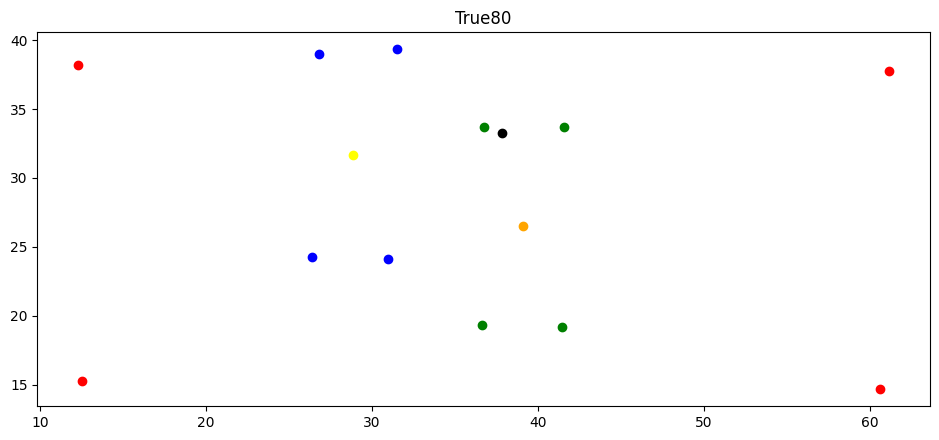

In [139]:
plt.figure(figsize=(9.5,4.5))
for ind, row in test.iterrows():
    plt.gca().set_title(str(row['odd'])+str(ind))

    plt.scatter([row['arenaTL_x_cm'] , row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')

    plt.scatter([row['recen_obstacleTL_x_cm_fh'], row['recen_obstacleTR_x_cm_fh'], row['recen_obstacleBL_x_cm_fh'], row['recen_obstacleBR_x_cm_fh']],
                [row['recen_obstacleTL_y_cm_fh'], row['recen_obstacleTR_y_cm_fh'], row['recen_obstacleBL_y_cm_fh'], row['recen_obstacleBR_y_cm_fh']],color='blue')

    plt.scatter([row['recen_obstacleTL_x_cm_lh'], row['recen_obstacleTR_x_cm_lh'], row['recen_obstacleBL_x_cm_lh'], row['recen_obstacleBR_x_cm_lh']],
                [row['recen_obstacleTL_y_cm_lh'], row['recen_obstacleTR_y_cm_lh'], row['recen_obstacleBL_y_cm_lh'], row['recen_obstacleBR_y_cm_lh']],color='green')
    
    
    plt.scatter(row['recen_obstacle_cen_x_cm_fh'],row['recen_obstacle_cen_y_cm_fh'],color='yellow')
    plt.scatter(row['recen_obstacle_cen_x_cm_lh'],row['recen_obstacle_cen_y_cm_lh'],color='orange')

    plt.scatter(row['recen_arena_cen_x_cm'],row['recen_arena_cen_y_cm'], color ='black')

   
    #sns.scatterplot(x=row['nose_x_cm'],y=row['nose_y_cm'],hue = row['nose_x_cm'], palette ='magma')

    plt.tight_layout()            
                

In [15]:
def format_frames(vid_path,dwnsmpl):
    # open the .avi file
    vidread = cv2.VideoCapture(vid_path)
    # empty array that is the target shape
    # should be number of frames x downsampled height x downsampled width
    #all_frames = np.empty([int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)),
                           #int(vidread.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                           #int(vidread.get(cv2.CAP_PROP_FRAME_WIDTH))], dtype=np.uint8)
     
    all_frames = np.empty([int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)),
                            int(vidread.get(cv2.CAP_PROP_FRAME_HEIGHT)*dwnsmpl),
                            int(vidread.get(cv2.CAP_PROP_FRAME_WIDTH)*dwnsmpl)], dtype=np.uint8)
    # iterate through each frame
    for frame_num in tqdm(range(0,int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)))):
        # read the frame in and make sure it is read in correctly
        ret, frame = vidread.read()
        if not ret:
            break
        # convert to grayyscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # downsample the frame by an amount specified in the config file
        sframe = cv2.resize(frame, (0,0), fx=dwnsmpl, fy=dwnsmpl, interpolation=cv2.INTER_NEAREST) 

        # add the downsampled frame to all_frames as int8
        all_frames[frame_num,:,:] = sframe.astype(np.uint8)
    #if not usexr:
        #return all_frames    
          
        # store the combined video frames in an xarray

    formatted_frames = xr.DataArray(all_frames.astype(np.uint8), dims=['frame', 'height', 'width'])
        # label frame numbers in the xarray
    formatted_frames.assign_coords({'frame':range(0,len(formatted_frames))})
        # delete all frames, since it's somewhat large in memory
    del all_frames
    return formatted_frames

In [45]:
def plot_traces():

SyntaxError: invalid syntax (803721154.py, line 1)

In [ ]:
def check_likellihood():

In [18]:
vid = format_frames(r'C:/Users/nlab/obstacle_avoidance/recordings\101422\J20RT\oa\101422_J20RT_control_Rig2_oa_top1.avi',.75)

100%|██████████| 31413/31413 [00:36<00:00, 852.84it/s]


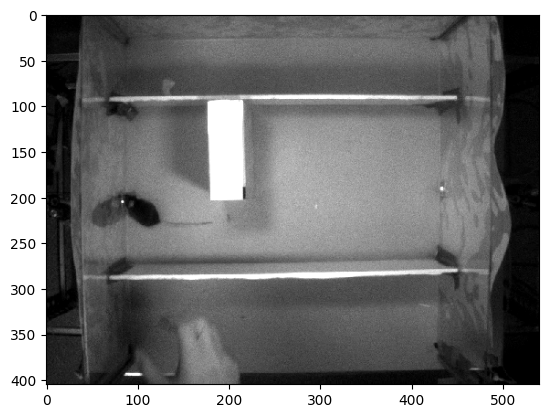

In [33]:
frame = vid[1000,:,:]
plt.imshow(frame, cmap='gray')

In [10]:
frames = vid[0:1000,:,:]

In [23]:
frames.shape

(1000, 540, 720)

In [27]:

np.array(df.at[1,'trial_vidframes'])

array([[1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
        1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
        1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
        1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
        1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
        1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
        1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
        1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
        2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
        2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
        2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
        2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
        2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
        2058, 2059, 2060, 2061, 2062, 

In [33]:
df.at[1,'trial_vidframes'].astype(int)[:,-1]

array([2157])

In [34]:
df.at[1,'trial_vidframes'].astype(int)[:,0]

array([1915])

In [52]:

for ind,row in df.iterrows():
    first_frame = row['trial_vidframes'][0]
    last_frame = row['trial_vidframes'][-1]
    df.at[ind,'trial_frames_array'] = vid[first_frame[0]:last_frame[-1],:,:].astype(object)

AttributeError: 'DataArray' object has no attribute 'take'

In [45]:
vid[first_frame[0]:last_frame[-1],:,:].astype(object).shape


(242, 540, 720)

In [33]:
row['trial_vidframes'][0]

2158

In [9]:
vid[first_frame:last_frame,:,:]

TypeError: only integer scalar arrays can be converted to a scalar index

In [14]:
first_frame[0]

1915

In [47]:
vid[first_frame[0]:last_frame[-1],:,:].shape

(242, 540, 720)

In [46]:
vid[first_frame[0]:last_frame[-1],:,:].astype(object)

array([[[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [15, 10, 12, ..., 0, 0, 0],
        [13, 11, 12, ..., 0, 0, 0],
        [13, 12, 12, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 3, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [13, 12, 10, ..., 0, 0, 0],
        [12, 11, 10, ..., 0, 0, 0],
        [11, 11, 11, ..., 0, 0, 0]],

       [[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [11, 9, 5, ..., 0, 0, 0],
        [11, 9, 6, ..., 0, 0, 0],
        [15, 12, 11, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        ...,
        [19, 18, 22, ..., 0, 0, 0],
        [15, 17, 17, ..., 0, 0, 0],
        [11, 16, 12, ..., 0, 0, 0]],

       [[2, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0],
    